In [61]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [62]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from tensorflow.keras import regularizers

In [63]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [64]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [65]:
tf.keras.backend.clear_session()

In [66]:
import shap
shap.initjs()

In [67]:
subject = 'Goiás - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 0
train_split = split_index + 1 - 12

In [68]:
data = pd.read_csv('2003_mo_model_input_GO.csv')
pd.set_option('display.max_columns', None)
data

Unnamed: 0  Goiás - Produção de Cimento (t)  \
0       2003-1                        56.459960   
1       2003-2                        56.789152   
2       2003-3                        57.140263   
3       2003-4                        57.649192   
4       2003-5                        58.213295   
..         ...                              ...   
256     2023-5                              NaN   
257     2023-6                              NaN   
258     2023-7                              NaN   
259     2023-8                              NaN   
260     2023-9                              NaN   

     Goiás - Consumo de Cimento (t)  Goiás - IDH Educacao  Goiás - IDH  \
0                            97.447              0.706514     0.745293   
1                            97.256              0.706866     0.745405   
2                           101.442              0.707217     0.745517   
3                            98.217              0.707569     0.745629   
4                           112.540              0.707920     0.745741   
..                              ...                   ...          ...   
256                             NaN                   NaN          NaN   
257                             NaN                   NaN          NaN   
258                             NaN                   NaN          NaN   
259                             NaN                   NaN          NaN   
260                             NaN                   NaN          NaN   

     Precipitação (mm/day)  Pressão Atmosférica (mB)  \
0                 2.213042                931.959546   
1                 2.021028                932.363097   
2                 1.823148                932.798217   
3                 1.756117                933.532125   
4                 1.331530                934.018275   
..                     ...                       ...   
256                    NaN                       NaN   
257                    NaN                       NaN   
258                    NaN                       NaN   
259                    NaN                       NaN   
260                    NaN                       NaN   

     Radiação Global - Dia (Kj/m²)  Temmperatura do Ar - Bulbo Seco (°C)  \
0                      1486.445398                             23.971618   
1                      1483.971093                             23.534386   
2                      1450.427392                             22.934067   
3                      1458.264605                             22.346879   
4                      1466.468143                             21.987268   
..                             ...                                   ...   
256                            NaN                                   NaN   
257                            NaN                                   NaN   
258                            NaN                                   NaN   
259                            NaN                                   NaN   
260                            NaN                                   NaN   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                               18.270239                    73.649051   
1                               17.704093                    73.006649   
2                               16.667652                    71.378895   
3                               15.045930                    67.632317   
4                               13.454185                    63.216002   
..                                    ...                          ...   
256                                   NaN                          NaN   
257                                   NaN                          NaN   
258                                   NaN                          NaN   
259                                   NaN                          NaN   
260                                   NaN                          NaN   

     Velocidade do Vento (m

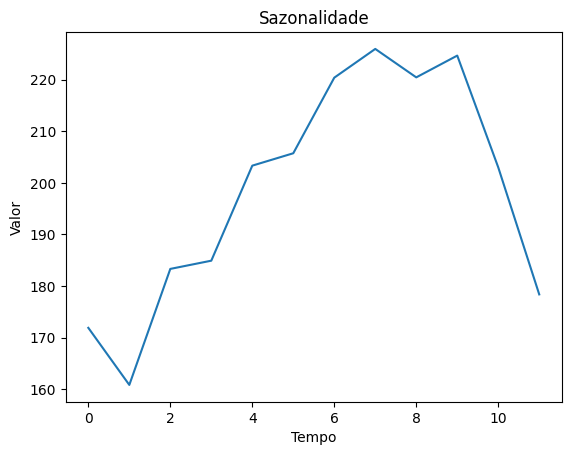

Sazonalidade
Sazonalidade              
0               171.893313
1               160.821351
2               183.321109
3               184.916194
4               203.346145
5               205.750017
6               220.410160
7               225.985065
8               220.469640
9               224.690902
10              203.018245
11              178.377071

In [69]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['Sazonalidade'] = df.index % 12
    monthly_means = df.groupby('Sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'Sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [70]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['Sazonalidade'].tolist()
    df_og['Sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

Unnamed: 0  Goiás - Produção de Cimento (t)  Goiás - IDH Educacao  \
0       2003-1                        56.459960              0.706514   
1       2003-2                        56.789152              0.706866   
2       2003-3                        57.140263              0.707217   
3       2003-4                        57.649192              0.707569   
4       2003-5                        58.213295              0.707920   
..         ...                              ...                   ...   
256     2023-5                              NaN                   NaN   
257     2023-6                              NaN                   NaN   
258     2023-7                              NaN                   NaN   
259     2023-8                              NaN                   NaN   
260     2023-9                              NaN                   NaN   

     Goiás - IDH  Precipitação (mm/day)  Pressão Atmosférica (mB)  \
0       0.745293               2.213042                931.959546   
1       0.745405               2.021028                932.363097   
2       0.745517               1.823148                932.798217   
3       0.745629               1.756117                933.532125   
4       0.745741               1.331530                934.018275   
..           ...                    ...                       ...   
256          NaN                    NaN                       NaN   
257          NaN                    NaN                       NaN   
258          NaN                    NaN                       NaN   
259          NaN                    NaN                       NaN   
260          NaN                    NaN                       NaN   

     Radiação Global - Dia (Kj/m²)  Temmperatura do Ar - Bulbo Seco (°C)  \
0                      1486.445398                             23.971618   
1                      1483.971093                             23.534386   
2                      1450.427392                             22.934067   
3                      1458.264605                             22.346879   
4                      1466.468143                             21.987268   
..                             ...                                   ...   
256                            NaN                                   NaN   
257                            NaN                                   NaN   
258                            NaN                                   NaN   
259                            NaN                                   NaN   
260                            NaN                                   NaN   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                               18.270239                    73.649051   
1                               17.704093                    73.006649   
2                               16.667652                    71.378895   
3                               15.045930                    67.632317   
4                               13.454185                    63.216002   
..                                    ...                          ...   
256                                   NaN                          NaN   
257                                   NaN                          NaN   
258                                   NaN                          NaN   
259                                   NaN                          NaN   
260                                   NaN                          NaN   

     Velocidade do Vento (m/s)  Goiás - IDH Longevidade  Goiás- custo m2 (R$)  \
0                     1.213018                 0.775614          10601.325200   
1                     1.243670                 0.775902          10688.670969   
2                     1.262206                 0.776190          10770.309117   
3                     1.355424                 0.776478          10847.723760   
4                     1.434779                 0.776766          10930.821691   
..        

In [71]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      121.831
1      115.210
2      122.721
3      130.262
4      139.268
        ...   
256        NaN
257        NaN
258        NaN
259        NaN
260        NaN
Name: Goiás - Consumo de Cimento (t), Length: 261, dtype: float64

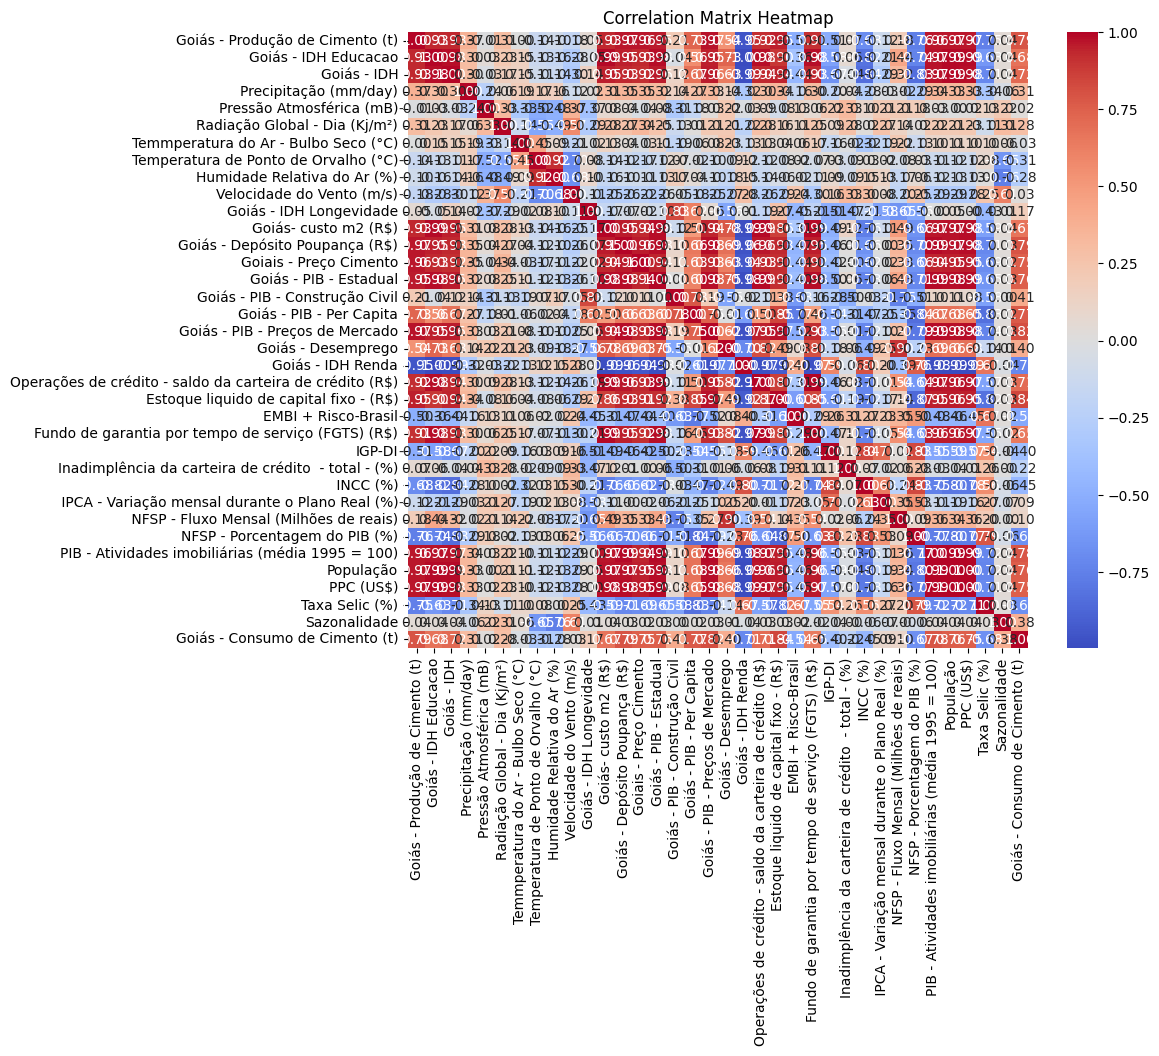

In [72]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [73]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [74]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

Feature           VIF
0                     Goiás - Produção de Cimento (t)  4.480357e+03
1                                Goiás - IDH Educacao  3.901750e+05
2                                         Goiás - IDH  4.470962e+08
3                               Precipitação (mm/day)  2.795385e+00
4                            Pressão Atmosférica (mB)  9.844027e+00
5                       Radiação Global - Dia (Kj/m²)  8.164701e+00
6                Temmperatura do Ar - Bulbo Seco (°C)  9.722850e+01
7                Temperatura de Ponto de Orvalho (°C)  8.030601e+02
8                         Humidade Relativa do Ar (%)  7.386938e+02
9                           Velocidade do Vento (m/s)  2.713844e+01
10                            Goiás - IDH Longevidade  2.395670e+04
11                               Goiás- custo m2 (R$)  2.370643e+05
12                     Goiás - Depósito Poupança (R$)  4.703985e+03
13                             Goiais - Preço Cimento  3.982106e+03
14                             Goiás - PIB - Estadual  1.270427e+06
15                     Goiás - PIB - Construção Civil  3.766506e+03
16                           Goiás - PIB - Per Capita  7.450714e+04
17                    Goiás - PIB - Preços de Mercado  1.171364e+06
18                                 Goiás - Desemprego  4.286850e+03
19                                  Goiás - IDH Renda  1.642415e+04
20  Operações de crédito - saldo da carteira de cr...  3.742271e+04
21             Estoque liquido de capital fixo - (R$)  2.292789e+05
22                                EMBI + Risco-Brasil  1.352238e+02
23  Fundo de garantia por tempo de serviço (FGTS) ...  3.393804e+02
24                                             IGP-DI  5.724092e+01
25  Inadimplência da carteira de crédito  - total ...  1.619812e+02
26                                           INCC (%)  1.645065e+02
27    IPCA - Variação mensal durante o Plano Real (%)  2.388238e+02
28             NFSP - Fluxo Mensal (Milhões de reais)  7.866277e+01
29                      NFSP - Porcentagem do PIB (%)  2.299249e+03
30   PIB - Atividades imobiliárias (média 1995 = 100)  1.067901e+04
31                                          População  3.169078e+05
32                                          PPC (US$)  2.140956e+05
33                                     Taxa Selic (%)  8.487480e+00
34                                       Sazonalidade  7.569918e+00

In [75]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 4


Goiás - Produção de Cimento (t)  Goiás - IDH Educacao  \
0                          56.459960              0.706514   
1                          56.789152              0.706866   
2                          57.140263              0.707217   
3                          57.649192              0.707569   
4                          58.213295              0.707920   
..                               ...                   ...   
175                       134.807122              0.759946   
176                       135.642275              0.760068   
177                       136.782331              0.760190   
178                       137.789488              0.760311   
179                       138.351298              0.760433   

     Precipitação (mm/day)  Pressão Atmosférica (mB)  \
0                 2.213042                931.959546   
1                 2.021028                932.363097   
2                 1.823148                932.798217   
3                 1.756117                933.532125   
4                 1.331530                934.018275   
..                     ...                       ...   
175               2.333679                932.871076   
176               2.163937                932.224476   
177               2.210665                931.478659   
178               2.362332                931.094998   
179               2.283871                930.996454   

     Radiação Global - Dia (Kj/m²)  Temmperatura do Ar - Bulbo Seco (°C)  \
0                      1486.445398                             23.971618   
1                      1483.971093                             23.534386   
2                      1450.427392                             22.934067   
3                      1458.264605                             22.346879   
4                      1466.468143                             21.987268   
..                             ...                                   ...   
175                    1512.415228                             24.196138   
176                    1479.994462                             24.417553   
177                    1456.292311                             24.504187   
178                    1415.584125                             24.224526   
179                    1421.685345                             24.244062   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                               18.270239                    73.649051   
1                               17.704093                    73.006649   
2                               16.667652                    71.378895   
3                               15.045930                    67.632317   
4                               13.454185                    63.216002   
..                                    ...                          ...   
175                             11.593019                    51.523052   
176                             12.845632                    54.954552   
177                             14.546376                    59.974041   
178                             16.058165                    65.514227   
179                             16.861048                    68.129422   

     Velocidade do Vento (m/s)  Goiás- custo m2 (R$)  \
0                     1.213018          10601.325200   
1                     1.243670          10688.670969   
2                     1.262206          10770.309117   
3                     1.355424          10847.723760   
4                     1.434779          10930.821691   
..                         ...                   ...   
175                   1.400376          24913.402421   
176                   1.401896          25013.012903   
177                   1.278549          25114.241274   
178                   1.186842          25207.714468   
179                   1.122669          25299.735279   

     Goiás - Depósito Poupança (R$)  Goiais - Preço Cimento  \
0                      3.935260e+06              

In [76]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

Goiás - IDH Educacao  Precipitação (mm/day)  Pressão Atmosférica (mB)  \
0               -1.785087               0.256388                 -0.143920   
1               -1.762678              -0.101646                  0.168942   
2               -1.740270              -0.470617                  0.506279   
3               -1.717861              -0.595604                  1.075258   
4               -1.695452              -1.387298                  1.452157   
..                    ...                    ...                       ...   
175              1.620090               0.481331                  0.562765   
176              1.627859               0.164826                  0.061473   
177              1.635628               0.251956                 -0.516739   
178              1.643398               0.534757                 -0.814181   
179              1.651167               0.388457                 -0.890579   

     Radiação Global - Dia (Kj/m²)  Temmperatura do Ar - Bulbo Seco (°C)  \
0                         0.926960                              0.365288   
1                         0.898846                             -0.181878   
2                         0.517708                             -0.933136   
3                         0.606758                             -1.667961   
4                         0.699970                             -2.117990   
..                             ...                                   ...   
175                       1.222041                              0.646260   
176                       0.853662                              0.923345   
177                       0.584348                              1.031762   
178                       0.121804                              0.681785   
179                       0.191129                              0.706233   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                                1.159444                     1.242571   
1                                0.895962                     1.141099   
2                                0.413607                     0.883985   
3                               -0.341137                     0.292189   
4                               -1.081929                    -0.405397   
..                                    ...                          ...   
175                             -1.948109                    -2.252373   
176                             -1.365147                    -1.710346   
177                             -0.573627                    -0.917485   
178                              0.129953                    -0.042377   
179                              0.503612                     0.370710   

     Velocidade do Vento (m/s)  Goiás- custo m2 (R$)  \
0                    -0.574742             -1.471077   
1                    -0.375227             -1.451452   
2                    -0.254579             -1.433110   
3                     0.352161             -1.415717   
4                     0.868674             -1.397046   
..                         ...                   ...   
175                   0.644751              1.744520   
176                   0.654645              1.766900   
177                  -0.148206              1.789644   
178                  -0.745119              1.810645   
179                  -1.162813              1.831320   

     Goiás - Depósito Poupança (R$)  Goiais - Preço Cimento  \
0                         -1.503688               -0.886364   
1                         -1.493304               -0.907289   
2                         -1.482919               -0.937020   
3                         -1.472535               -0.963285   
4                         -1.462151               -0.996868   
..                              ...                     ...   
175                        1.247061                1.231466   
176                        1.270454                1.243232   
177                       

In [77]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

Goiás - IDH Educacao  Precipitação (mm/day)  Pressão Atmosférica (mB)  \
0               -1.785087               0.256388                 -0.143920   
1               -1.762678              -0.101646                  0.168942   
2               -1.740270              -0.470617                  0.506279   
3               -1.717861              -0.595604                  1.075258   
4               -1.695452              -1.387298                  1.452157   
..                    ...                    ...                       ...   
163              1.554436              -1.343221                  0.470874   
164              1.556689              -0.878331                 -0.015662   
165              1.558943              -0.277151                 -0.382535   
166              1.561197              -0.201267                 -0.555214   
167              1.563450               0.415688                 -0.577382   

     Radiação Global - Dia (Kj/m²)  Temmperatura do Ar - Bulbo Seco (°C)  \
0                         0.926960                              0.365288   
1                         0.898846                             -0.181878   
2                         0.517708                             -0.933136   
3                         0.606758                             -1.667961   
4                         0.699970                             -2.117990   
..                             ...                                   ...   
163                       0.643465                              0.846985   
164                       0.693820                              1.153913   
165                       0.409021                              1.030930   
166                       0.189325                              0.855761   
167                       0.407930                              0.915997   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                                1.159444                     1.242571   
1                                0.895962                     1.141099   
2                                0.413607                     0.883985   
3                               -0.341137                     0.292189   
4                               -1.081929                    -0.405397   
..                                    ...                          ...   
163                             -0.992250                    -1.472477   
164                             -0.483520                    -1.032337   
165                              0.125463                    -0.321004   
166                              0.519169                     0.199234   
167                              0.754610                     0.447557   

     Velocidade do Vento (m/s)  Goiás- custo m2 (R$)  \
0                    -0.574742             -1.471077   
1                    -0.375227             -1.451452   
2                    -0.254579             -1.433110   
3                     0.352161             -1.415717   
4                     0.868674             -1.397046   
..                         ...                   ...   
163                   0.086590              1.499631   
164                   0.163436              1.519776   
165                  -0.134049              1.540339   
166                  -0.342042              1.560512   
167                  -0.614022              1.580837   

     Goiás - Depósito Poupança (R$)  Goiais - Preço Cimento  \
0                         -1.503688               -0.886364   
1                         -1.493304               -0.907289   
2                         -1.482919               -0.937020   
3                         -1.472535               -0.963285   
4                         -1.462151               -0.996868   
..                              ...                     ...   
163                        0.979509                1.097275   
164                        1.000270                1.105888   
165                       

In [78]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      121.831
1      115.210
2      122.721
3      130.262
4      139.268
        ...   
163    224.270
164    213.871
165    211.066
166    182.899
167    159.002
Name: Goiás - Consumo de Cimento (t), Length: 168, dtype: float64

In [79]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

Goiás - IDH Educacao  Precipitação (mm/day)  Pressão Atmosférica (mB)  \
168              1.565704               0.861337                 -0.501426   
169              1.573474               1.510660                 -0.302724   
170              1.581243               1.508296                  0.179853   
171              1.589012               1.712849                  1.008179   
172              1.596782               1.683679                  1.375124   
173              1.604551               0.667127                  1.698457   
174              1.612320               0.754016                  1.407923   
175              1.620090               0.481331                  0.562765   
176              1.627859               0.164826                  0.061473   
177              1.635628               0.251956                 -0.516739   
178              1.643398               0.534757                 -0.814181   
179              1.651167               0.388457                 -0.890579   

     Radiação Global - Dia (Kj/m²)  Temmperatura do Ar - Bulbo Seco (°C)  \
168                       0.420897                              0.906035   
169                       0.275918                              0.653645   
170                       0.106338                              0.160252   
171                       0.157468                             -0.806989   
172                       0.260843                             -1.202846   
173                       0.714032                             -1.113708   
174                       1.267796                             -0.287407   
175                       1.222041                              0.646260   
176                       0.853662                              0.923345   
177                       0.584348                              1.031762   
178                       0.121804                              0.681785   
179                       0.191129                              0.706233   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
168                              0.940902                     0.662719   
169                              0.916237                     0.732734   
170                              0.595631                     0.543854   
171                             -0.121752                     0.070700   
172                             -0.956084                    -0.660124   
173                             -1.840265                    -1.600824   
174                             -2.269684                    -2.310584   
175                             -1.948109                    -2.252373   
176                             -1.365147                    -1.710346   
177                             -0.573627                    -0.917485   
178                              0.129953                    -0.042377   
179                              0.503612                     0.370710   

     Velocidade do Vento (m/s)  Goiás- custo m2 (R$)  \
168                  -1.009942              1.601278   
169                  -1.243051              1.621284   
170                  -1.046074              1.641684   
171                  -0.276440              1.662071   
172                  -0.095513              1.681966   
173                   0.835117              1.702240   
174                   1.119531              1.721830   
175                   0.644751              1.744520   
176                   0.654645              1.766900   
177                  -0.148206              1.789644   
178                  -0.745119              1.810645   
179                  -1.162813              1.831320   

     Goiás - Depósito Poupança (R$)  Goiais - Preço Cimento  \
168                        1.083313                1.143332   
169                        1.106705                1.158339   
170                        1.130098                1.173473   
171                        1.153491                1.1849

In [80]:
# Alvo para teste
test_target = target_data.iloc[train_split - window_size:split_index + 1]
test_target

168    178.918
169    161.936
170    173.792
171    176.627
172    207.991
173    185.784
174    234.176
175    226.996
176    218.141
177    234.939
178    199.619
179    168.797
Name: Goiás - Consumo de Cimento (t), dtype: float64

In [81]:
# Rede neural feed-forward com optmizador Estocástico
def neural_network_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2(0.01), 
                              input_shape=(train_input.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train_input, 
                      train_target, 
                      epochs=10000,
                      validation_split=0.07,
                      callbacks=[early_stopping], 
                      verbose=want_verbose)
    return model, history

In [82]:
winner_seed = 188887958

In [83]:
trained_model, history = neural_network_model(train_input, train_target, want_verbose=1, seed=winner_seed)
# 188887958

Epoch 1/10000
5/5 [==============================] - 0s 22ms/step - loss: 43133.7617 - val_loss: 56963.0898
Epoch 2/10000
5/5 [==============================] - 0s 5ms/step - loss: 26343.4160 - val_loss: 102848.6562
Epoch 3/10000
5/5 [==============================] - 0s 4ms/step - loss: 22010.1895 - val_loss: 45309.3281
Epoch 4/10000
5/5 [==============================] - 0s 4ms/step - loss: 5414.1699 - val_loss: 6069.6577
Epoch 5/10000
5/5 [==============================] - 0s 4ms/step - loss: 1181.4037 - val_loss: 6807.7930
Epoch 6/10000
5/5 [==============================] - 0s 4ms/step - loss: 792.4797 - val_loss: 9258.2881
Epoch 7/10000
5/5 [==============================] - 0s 4ms/step - loss: 978.5040 - val_loss: 39874.8828
Epoch 8/10000
5/5 [==============================] - 0s 4ms/step - loss: 752.0855 - val_loss: 25474.1504
Epoch 9/10000
5/5 [==============================] - 0s 4ms/step - loss: 671.1002 - val_loss: 9435.4541
Epoch 10/10000
5/5 [=============================

5/5 [==============================] - 0s 4ms/step - loss: 505.1591 - val_loss: 15402.2734
Epoch 80/10000
5/5 [==============================] - 0s 4ms/step - loss: 382.2657 - val_loss: 775.5220
Epoch 81/10000
5/5 [==============================] - 0s 4ms/step - loss: 409.6867 - val_loss: 3931.8191
Epoch 82/10000
5/5 [==============================] - 0s 4ms/step - loss: 380.0841 - val_loss: 683.3594
Epoch 83/10000
5/5 [==============================] - 0s 4ms/step - loss: 377.2719 - val_loss: 519.9904
Epoch 84/10000
5/5 [==============================] - 0s 4ms/step - loss: 427.4355 - val_loss: 1642.8883
Epoch 85/10000
5/5 [==============================] - 0s 4ms/step - loss: 395.0483 - val_loss: 717.0178
Epoch 86/10000
5/5 [==============================] - 0s 4ms/step - loss: 396.1335 - val_loss: 1960.2941
Epoch 87/10000
5/5 [==============================] - 0s 4ms/step - loss: 385.1764 - val_loss: 3862.3428
Epoch 88/10000
5/5 [==============================] - 0s 4ms/step - loss:

5/5 [==============================] - 0s 4ms/step - loss: 335.3010 - val_loss: 484.0133
Epoch 158/10000
5/5 [==============================] - 0s 4ms/step - loss: 357.5872 - val_loss: 536.2563
Epoch 159/10000
5/5 [==============================] - 0s 4ms/step - loss: 313.7784 - val_loss: 471.0092
Epoch 160/10000
5/5 [==============================] - 0s 4ms/step - loss: 359.6168 - val_loss: 454.3579
Epoch 161/10000
5/5 [==============================] - 0s 4ms/step - loss: 345.4547 - val_loss: 519.4741
Epoch 162/10000
5/5 [==============================] - 0s 4ms/step - loss: 323.8994 - val_loss: 518.8029
Epoch 163/10000
5/5 [==============================] - 0s 4ms/step - loss: 353.4597 - val_loss: 517.4777
Epoch 164/10000
5/5 [==============================] - 0s 4ms/step - loss: 340.3099 - val_loss: 501.2052
Epoch 165/10000
5/5 [==============================] - 0s 4ms/step - loss: 370.3337 - val_loss: 483.0251
Epoch 166/10000
5/5 [==============================] - 0s 4ms/step - lo

5/5 [==============================] - 0s 4ms/step - loss: 291.9569 - val_loss: 2414.1479
Epoch 236/10000
5/5 [==============================] - 0s 4ms/step - loss: 300.4952 - val_loss: 3243.0623
Epoch 237/10000
5/5 [==============================] - 0s 4ms/step - loss: 317.3310 - val_loss: 3992.8655
Epoch 238/10000
5/5 [==============================] - 0s 4ms/step - loss: 294.1051 - val_loss: 3673.2200
Epoch 239/10000
5/5 [==============================] - 0s 4ms/step - loss: 299.0117 - val_loss: 1453.0280
Epoch 240/10000
5/5 [==============================] - 0s 4ms/step - loss: 313.3128 - val_loss: 1072.4618
Epoch 241/10000
5/5 [==============================] - 0s 4ms/step - loss: 290.8998 - val_loss: 1431.5142
Epoch 242/10000
5/5 [==============================] - 0s 4ms/step - loss: 346.7119 - val_loss: 449.1975
Epoch 243/10000
5/5 [==============================] - 0s 4ms/step - loss: 329.2331 - val_loss: 662.2957
Epoch 244/10000
5/5 [==============================] - 0s 4ms/st

Epoch 313/10000
5/5 [==============================] - 0s 4ms/step - loss: 272.3104 - val_loss: 587.5983
Epoch 314/10000
5/5 [==============================] - 0s 4ms/step - loss: 295.9990 - val_loss: 614.9315
Epoch 315/10000
5/5 [==============================] - 0s 4ms/step - loss: 269.0165 - val_loss: 727.7300
Epoch 316/10000
5/5 [==============================] - 0s 4ms/step - loss: 247.8163 - val_loss: 870.7463
Epoch 317/10000
5/5 [==============================] - 0s 4ms/step - loss: 323.8048 - val_loss: 755.5058
Epoch 318/10000
5/5 [==============================] - 0s 4ms/step - loss: 316.7035 - val_loss: 912.3738
Epoch 319/10000
5/5 [==============================] - 0s 4ms/step - loss: 322.6633 - val_loss: 1998.4982
Epoch 320/10000
5/5 [==============================] - 0s 4ms/step - loss: 309.8240 - val_loss: 1939.8468
Epoch 321/10000
5/5 [==============================] - 0s 4ms/step - loss: 297.2070 - val_loss: 2101.6797
Epoch 322/10000
5/5 [==============================]

Epoch 391/10000
5/5 [==============================] - 0s 4ms/step - loss: 258.9728 - val_loss: 529.9076
Epoch 392/10000
5/5 [==============================] - 0s 4ms/step - loss: 272.9004 - val_loss: 518.8728
Epoch 393/10000
5/5 [==============================] - 0s 4ms/step - loss: 271.4757 - val_loss: 491.7605
Epoch 394/10000
5/5 [==============================] - 0s 5ms/step - loss: 257.7248 - val_loss: 521.4052
Epoch 395/10000
5/5 [==============================] - 0s 4ms/step - loss: 250.5747 - val_loss: 515.0156
Epoch 396/10000
5/5 [==============================] - 0s 4ms/step - loss: 291.9821 - val_loss: 489.0426
Epoch 397/10000
5/5 [==============================] - 0s 4ms/step - loss: 271.2286 - val_loss: 479.1975
Epoch 398/10000
5/5 [==============================] - 0s 4ms/step - loss: 296.8719 - val_loss: 578.4588
Epoch 399/10000
5/5 [==============================] - 0s 4ms/step - loss: 256.8628 - val_loss: 725.6662
Epoch 400/10000
5/5 [==============================] - 

Epoch 469/10000
5/5 [==============================] - 0s 4ms/step - loss: 368.1691 - val_loss: 1650.0826
Epoch 470/10000
5/5 [==============================] - 0s 5ms/step - loss: 317.3213 - val_loss: 2047.1366
Epoch 471/10000
5/5 [==============================] - 0s 4ms/step - loss: 287.5947 - val_loss: 1695.9443
Epoch 472/10000
5/5 [==============================] - 0s 4ms/step - loss: 303.6061 - val_loss: 2812.1816
Epoch 473/10000
5/5 [==============================] - 0s 4ms/step - loss: 276.3669 - val_loss: 2091.0808
Epoch 474/10000
5/5 [==============================] - 0s 4ms/step - loss: 271.8498 - val_loss: 2852.7390
Epoch 475/10000
5/5 [==============================] - 0s 4ms/step - loss: 293.8659 - val_loss: 3424.9973
Epoch 476/10000
5/5 [==============================] - 0s 4ms/step - loss: 249.2598 - val_loss: 3517.1750
Epoch 477/10000
5/5 [==============================] - 0s 4ms/step - loss: 336.1245 - val_loss: 3005.4690
Epoch 478/10000
5/5 [=========================

5/5 [==============================] - 0s 4ms/step - loss: 231.8305 - val_loss: 547.0735
Epoch 625/10000
5/5 [==============================] - 0s 4ms/step - loss: 225.3739 - val_loss: 476.1230
Epoch 626/10000
5/5 [==============================] - 0s 4ms/step - loss: 244.5241 - val_loss: 483.3773
Epoch 627/10000
5/5 [==============================] - 0s 4ms/step - loss: 233.9249 - val_loss: 460.7083
Epoch 628/10000
5/5 [==============================] - 0s 4ms/step - loss: 225.4093 - val_loss: 387.7223
Epoch 629/10000
5/5 [==============================] - 0s 4ms/step - loss: 239.7438 - val_loss: 499.3181
Epoch 630/10000
5/5 [==============================] - 0s 4ms/step - loss: 264.4593 - val_loss: 524.1033
Epoch 631/10000
5/5 [==============================] - 0s 4ms/step - loss: 249.7421 - val_loss: 564.6688
Epoch 632/10000
5/5 [==============================] - 0s 4ms/step - loss: 235.9156 - val_loss: 594.3257
Epoch 633/10000
5/5 [==============================] - 0s 4ms/step - lo

5/5 [==============================] - 0s 4ms/step - loss: 209.1142 - val_loss: 437.0609
Epoch 703/10000
5/5 [==============================] - 0s 4ms/step - loss: 209.9189 - val_loss: 558.1578
Epoch 704/10000
5/5 [==============================] - 0s 4ms/step - loss: 217.1310 - val_loss: 633.7134
Epoch 705/10000
5/5 [==============================] - 0s 4ms/step - loss: 212.5890 - val_loss: 559.9763
Epoch 706/10000
5/5 [==============================] - 0s 4ms/step - loss: 218.1940 - val_loss: 525.0317
Epoch 707/10000
5/5 [==============================] - 0s 4ms/step - loss: 203.7723 - val_loss: 527.3387
Epoch 708/10000
5/5 [==============================] - 0s 4ms/step - loss: 235.9033 - val_loss: 558.7426
Epoch 709/10000
5/5 [==============================] - 0s 4ms/step - loss: 231.5861 - val_loss: 524.2883
Epoch 710/10000
5/5 [==============================] - 0s 4ms/step - loss: 218.3875 - val_loss: 616.5377
Epoch 711/10000
5/5 [==============================] - 0s 4ms/step - lo

5/5 [==============================] - 0s 4ms/step - loss: 250.5826 - val_loss: 599.0141
Epoch 859/10000
5/5 [==============================] - 0s 4ms/step - loss: 235.2007 - val_loss: 625.3497
Epoch 860/10000
5/5 [==============================] - 0s 4ms/step - loss: 226.1122 - val_loss: 598.5097
Epoch 861/10000
5/5 [==============================] - 0s 4ms/step - loss: 267.0376 - val_loss: 636.6526
Epoch 862/10000
5/5 [==============================] - 0s 4ms/step - loss: 246.1250 - val_loss: 613.2085
Epoch 863/10000
5/5 [==============================] - 0s 4ms/step - loss: 222.3168 - val_loss: 583.8146
Epoch 864/10000
5/5 [==============================] - 0s 4ms/step - loss: 215.4234 - val_loss: 563.5258
Epoch 865/10000
5/5 [==============================] - 0s 4ms/step - loss: 249.1551 - val_loss: 3113.4785
Epoch 866/10000
5/5 [==============================] - 0s 4ms/step - loss: 273.4354 - val_loss: 1074.7262
Epoch 867/10000
5/5 [==============================] - 0s 4ms/step - 

5/5 [==============================] - 0s 4ms/step - loss: 251.0650 - val_loss: 381.2494
Epoch 937/10000
5/5 [==============================] - 0s 4ms/step - loss: 246.8301 - val_loss: 417.1881
Epoch 938/10000
5/5 [==============================] - 0s 4ms/step - loss: 239.9560 - val_loss: 416.7495
Epoch 939/10000
5/5 [==============================] - 0s 4ms/step - loss: 272.0501 - val_loss: 466.8181
Epoch 940/10000
5/5 [==============================] - 0s 4ms/step - loss: 229.5372 - val_loss: 441.6615
Epoch 941/10000
5/5 [==============================] - 0s 4ms/step - loss: 230.3968 - val_loss: 507.6662
Epoch 942/10000
5/5 [==============================] - 0s 4ms/step - loss: 230.4993 - val_loss: 611.0182
Epoch 943/10000
5/5 [==============================] - 0s 4ms/step - loss: 260.8939 - val_loss: 621.6050
Epoch 944/10000
5/5 [==============================] - 0s 4ms/step - loss: 229.7362 - val_loss: 525.4771
Epoch 945/10000
5/5 [==============================] - 0s 4ms/step - lo

5/5 [==============================] - 0s 4ms/step - loss: 241.8205 - val_loss: 505.3299
Epoch 1015/10000
5/5 [==============================] - 0s 4ms/step - loss: 232.1154 - val_loss: 472.3584
Epoch 1016/10000
5/5 [==============================] - 0s 5ms/step - loss: 225.1533 - val_loss: 561.7927
Epoch 1017/10000
5/5 [==============================] - 0s 4ms/step - loss: 226.0403 - val_loss: 600.9023
Epoch 1018/10000
5/5 [==============================] - 0s 4ms/step - loss: 223.3423 - val_loss: 601.4866
Epoch 1019/10000
5/5 [==============================] - 0s 4ms/step - loss: 213.1488 - val_loss: 701.5533
Epoch 1020/10000
5/5 [==============================] - 0s 4ms/step - loss: 219.2849 - val_loss: 593.7896
Epoch 1021/10000
5/5 [==============================] - 0s 4ms/step - loss: 230.0620 - val_loss: 611.7278
Epoch 1022/10000
5/5 [==============================] - 0s 4ms/step - loss: 231.0060 - val_loss: 635.5644
Epoch 1023/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 4ms/step - loss: 243.8162 - val_loss: 406.5180
Epoch 1169/10000
5/5 [==============================] - 0s 4ms/step - loss: 260.0519 - val_loss: 391.7660
Epoch 1170/10000
5/5 [==============================] - 0s 4ms/step - loss: 273.4144 - val_loss: 385.1425
Epoch 1171/10000
5/5 [==============================] - 0s 4ms/step - loss: 255.5544 - val_loss: 709.9930
Epoch 1172/10000
5/5 [==============================] - 0s 4ms/step - loss: 318.9258 - val_loss: 662.4327
Epoch 1173/10000
5/5 [==============================] - 0s 4ms/step - loss: 275.7897 - val_loss: 656.7548
Epoch 1174/10000
5/5 [==============================] - 0s 4ms/step - loss: 265.3347 - val_loss: 690.0399
Epoch 1175/10000
5/5 [==============================] - 0s 4ms/step - loss: 271.5141 - val_loss: 875.4517
Epoch 1176/10000
5/5 [==============================] - 0s 4ms/step - loss: 242.4573 - val_loss: 733.8665
Epoch 1177/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 4ms/step - loss: 222.6023 - val_loss: 579.2911
Epoch 1323/10000
5/5 [==============================] - 0s 4ms/step - loss: 204.3160 - val_loss: 610.2280
Epoch 1324/10000
5/5 [==============================] - 0s 4ms/step - loss: 227.8748 - val_loss: 752.2922
Epoch 1325/10000
5/5 [==============================] - 0s 4ms/step - loss: 246.9385 - val_loss: 819.6921
Epoch 1326/10000
5/5 [==============================] - 0s 4ms/step - loss: 210.2291 - val_loss: 674.6874
Epoch 1327/10000
5/5 [==============================] - 0s 4ms/step - loss: 215.2661 - val_loss: 602.7375
Epoch 1328/10000
5/5 [==============================] - 0s 4ms/step - loss: 237.7459 - val_loss: 603.9270
Epoch 1329/10000
5/5 [==============================] - 0s 4ms/step - loss: 236.1735 - val_loss: 571.3052
Epoch 1330/10000
5/5 [==============================] - 0s 4ms/step - loss: 244.9536 - val_loss: 521.0625
Epoch 1331/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 4ms/step - loss: 217.6671 - val_loss: 1338.5939
Epoch 1477/10000
5/5 [==============================] - 0s 4ms/step - loss: 239.0339 - val_loss: 1456.5931
Epoch 1478/10000
5/5 [==============================] - 0s 4ms/step - loss: 236.8376 - val_loss: 775.3223
Epoch 1479/10000
5/5 [==============================] - 0s 4ms/step - loss: 206.9844 - val_loss: 795.9043
Epoch 1480/10000
5/5 [==============================] - 0s 4ms/step - loss: 223.7614 - val_loss: 785.6993
Epoch 1481/10000
5/5 [==============================] - 0s 4ms/step - loss: 211.7556 - val_loss: 780.5914
Epoch 1482/10000
5/5 [==============================] - 0s 4ms/step - loss: 198.2353 - val_loss: 789.1584
Epoch 1483/10000
5/5 [==============================] - 0s 4ms/step - loss: 211.7938 - val_loss: 616.6876
Epoch 1484/10000
5/5 [==============================] - 0s 4ms/step - loss: 230.6243 - val_loss: 633.1822
Epoch 1485/10000
5/5 [==============================] - 0s 4m

5/5 [==============================] - 0s 4ms/step - loss: 198.2139 - val_loss: 524.3125
Epoch 1631/10000
5/5 [==============================] - 0s 4ms/step - loss: 209.4291 - val_loss: 539.1770
Epoch 1632/10000
5/5 [==============================] - 0s 4ms/step - loss: 202.7193 - val_loss: 522.3806
Epoch 1633/10000
5/5 [==============================] - 0s 4ms/step - loss: 205.9834 - val_loss: 508.5397
Epoch 1634/10000
5/5 [==============================] - 0s 4ms/step - loss: 200.5813 - val_loss: 511.3168
Epoch 1635/10000
5/5 [==============================] - 0s 4ms/step - loss: 186.2502 - val_loss: 587.6351
Epoch 1636/10000
5/5 [==============================] - 0s 4ms/step - loss: 192.2958 - val_loss: 543.7533
Epoch 1637/10000
5/5 [==============================] - 0s 4ms/step - loss: 197.5809 - val_loss: 465.5241
Epoch 1638/10000
5/5 [==============================] - 0s 4ms/step - loss: 197.3022 - val_loss: 514.3322
Epoch 1639/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 4ms/step - loss: 184.0989 - val_loss: 628.7744
Epoch 1785/10000
5/5 [==============================] - 0s 4ms/step - loss: 164.6252 - val_loss: 627.4541
Epoch 1786/10000
5/5 [==============================] - 0s 4ms/step - loss: 201.5399 - val_loss: 627.8127
Epoch 1787/10000
5/5 [==============================] - 0s 4ms/step - loss: 185.8969 - val_loss: 628.9366
Epoch 1788/10000
5/5 [==============================] - 0s 4ms/step - loss: 171.8361 - val_loss: 628.7744
Epoch 1789/10000
5/5 [==============================] - 0s 4ms/step - loss: 169.4766 - val_loss: 570.6416
Epoch 1790/10000
5/5 [==============================] - 0s 4ms/step - loss: 179.7894 - val_loss: 573.4833
Epoch 1791/10000
5/5 [==============================] - 0s 4ms/step - loss: 173.3791 - val_loss: 523.2905
Epoch 1792/10000
5/5 [==============================] - 0s 4ms/step - loss: 169.3295 - val_loss: 524.0555
Epoch 1793/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 4ms/step - loss: 235.7388 - val_loss: 469.6797
Epoch 1939/10000
5/5 [==============================] - 0s 4ms/step - loss: 202.6407 - val_loss: 245.2111
Epoch 1940/10000
5/5 [==============================] - 0s 4ms/step - loss: 230.4306 - val_loss: 469.0037
Epoch 1941/10000
5/5 [==============================] - 0s 4ms/step - loss: 203.0706 - val_loss: 509.7387
Epoch 1942/10000
5/5 [==============================] - 0s 4ms/step - loss: 192.0287 - val_loss: 502.6432
Epoch 1943/10000
5/5 [==============================] - 0s 4ms/step - loss: 189.9660 - val_loss: 523.1267
Epoch 1944/10000
5/5 [==============================] - 0s 4ms/step - loss: 191.5301 - val_loss: 440.8431
Epoch 1945/10000
5/5 [==============================] - 0s 4ms/step - loss: 204.9102 - val_loss: 414.8080
Epoch 1946/10000
5/5 [==============================] - 0s 4ms/step - loss: 196.4154 - val_loss: 469.5487
Epoch 1947/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 4ms/step - loss: 154.0416 - val_loss: 448.4369
Epoch 2093/10000
5/5 [==============================] - 0s 4ms/step - loss: 152.5617 - val_loss: 489.3471
Epoch 2094/10000
5/5 [==============================] - 0s 4ms/step - loss: 163.3708 - val_loss: 507.0562
Epoch 2095/10000
5/5 [==============================] - 0s 4ms/step - loss: 155.8192 - val_loss: 482.7757
Epoch 2096/10000
5/5 [==============================] - 0s 5ms/step - loss: 158.4500 - val_loss: 480.9723
Epoch 2097/10000
5/5 [==============================] - 0s 5ms/step - loss: 157.5116 - val_loss: 467.4875
Epoch 2098/10000
5/5 [==============================] - 0s 4ms/step - loss: 157.0152 - val_loss: 463.5070
Epoch 2099/10000
5/5 [==============================] - 0s 4ms/step - loss: 151.2604 - val_loss: 500.7013
Epoch 2100/10000
5/5 [==============================] - 0s 4ms/step - loss: 150.3771 - val_loss: 479.0834
Epoch 2101/10000
5/5 [==============================] - 0s 5ms/

5/5 [==============================] - 0s 4ms/step - loss: 131.9742 - val_loss: 497.9741
Epoch 2247/10000
5/5 [==============================] - 0s 4ms/step - loss: 129.5258 - val_loss: 487.1344
Epoch 2248/10000
5/5 [==============================] - 0s 4ms/step - loss: 135.7776 - val_loss: 500.6698
Epoch 2249/10000
5/5 [==============================] - 0s 4ms/step - loss: 137.1560 - val_loss: 455.1171
Epoch 2250/10000
5/5 [==============================] - 0s 4ms/step - loss: 146.5372 - val_loss: 466.0143
Epoch 2251/10000
5/5 [==============================] - 0s 4ms/step - loss: 134.5541 - val_loss: 508.2477
Epoch 2252/10000
5/5 [==============================] - 0s 4ms/step - loss: 138.3405 - val_loss: 504.3997
Epoch 2253/10000
5/5 [==============================] - 0s 4ms/step - loss: 134.6401 - val_loss: 515.0211
Epoch 2254/10000
5/5 [==============================] - 0s 4ms/step - loss: 130.1142 - val_loss: 509.4613
Epoch 2255/10000
5/5 [==============================] - 0s 4ms/

5/5 [==============================] - 0s 5ms/step - loss: 126.8787 - val_loss: 566.2458
Epoch 2401/10000
5/5 [==============================] - 0s 5ms/step - loss: 126.4202 - val_loss: 568.5365
Epoch 2402/10000
5/5 [==============================] - 0s 5ms/step - loss: 132.8281 - val_loss: 565.1188
Epoch 2403/10000
5/5 [==============================] - 0s 5ms/step - loss: 123.7439 - val_loss: 569.1784
Epoch 2404/10000
5/5 [==============================] - 0s 4ms/step - loss: 133.0694 - val_loss: 567.2882
Epoch 2405/10000
5/5 [==============================] - 0s 4ms/step - loss: 128.5679 - val_loss: 528.2944
Epoch 2406/10000
5/5 [==============================] - 0s 4ms/step - loss: 122.4084 - val_loss: 528.0329
Epoch 2407/10000
5/5 [==============================] - 0s 5ms/step - loss: 127.2610 - val_loss: 538.8208
Epoch 2408/10000
5/5 [==============================] - 0s 4ms/step - loss: 132.4631 - val_loss: 525.3257
Epoch 2409/10000
5/5 [==============================] - 0s 4ms/

In [84]:
trained_model.save('model_go.keras')

In [85]:
def f(X):
    model = tf.keras.models.load_model('model_sp.keras')
    return model.predict(X)

def shap_explainer(train_input, test_input, test_target):
    explainer = shap.KernelExplainer(f, pd.DataFrame(np.zeros((1, len(train_input.columns.tolist()))), columns=test_input.columns))
    shap_values = explainer.shap_values(test_input)
    exp = shap.Explanation(shap_values[0], explainer.expected_value, test_input, feature_names=test_input.columns)
    display(shap.waterfall_plot(exp[0]))
#     display(shap.summary_plot(shap_values, features=test_input))
    display(shap.decision_plot(test_target, shap_values[0], test_input))
    return shap_values[0][0], explainer

def mae_mape_calculator(model, train_input, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        input_i = test_input[i:i+1]
        prediction = model.predict(input_i)
        target = test_target.iloc[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        info = [f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]]
        results_data.append(info)
        shap_calc_values, exp = shap_explainer(train_input, input_i, target)
        display(info)

       

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 595us/step


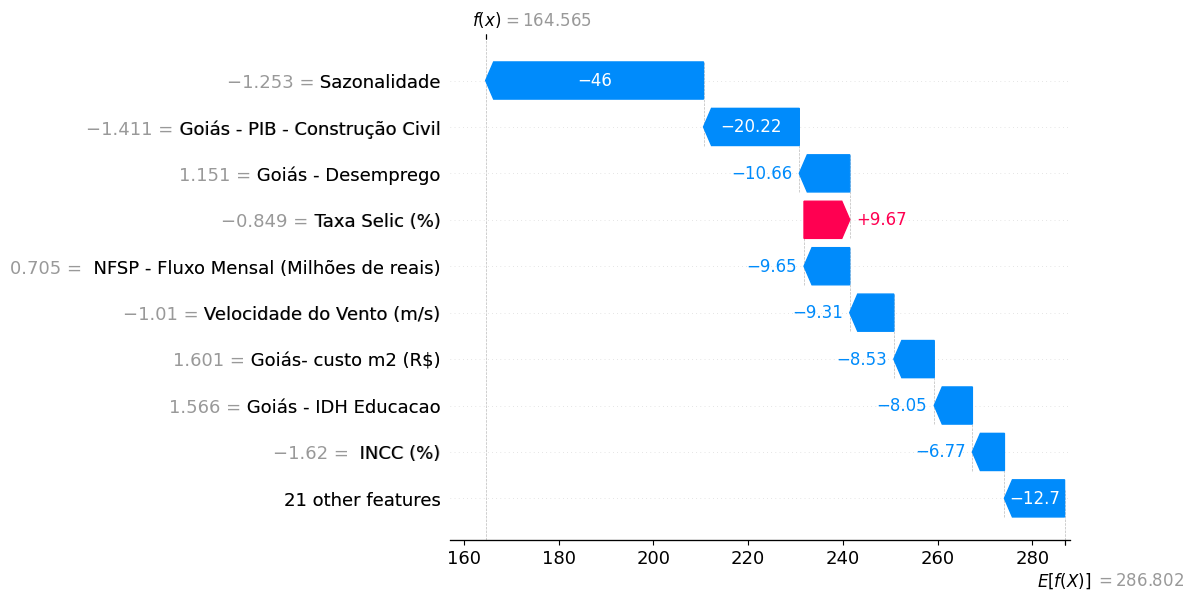

None

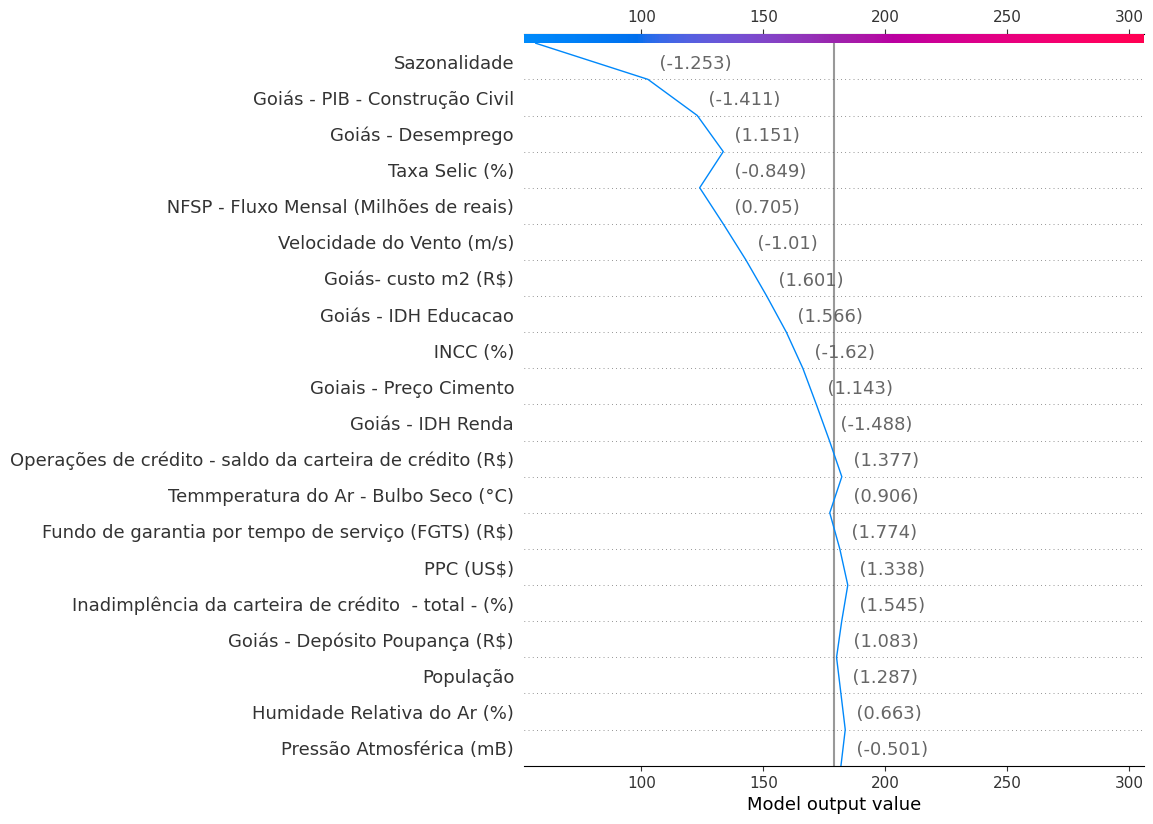

None

['Month-1', 164.56474, 178.918, 14.353256]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 613us/step


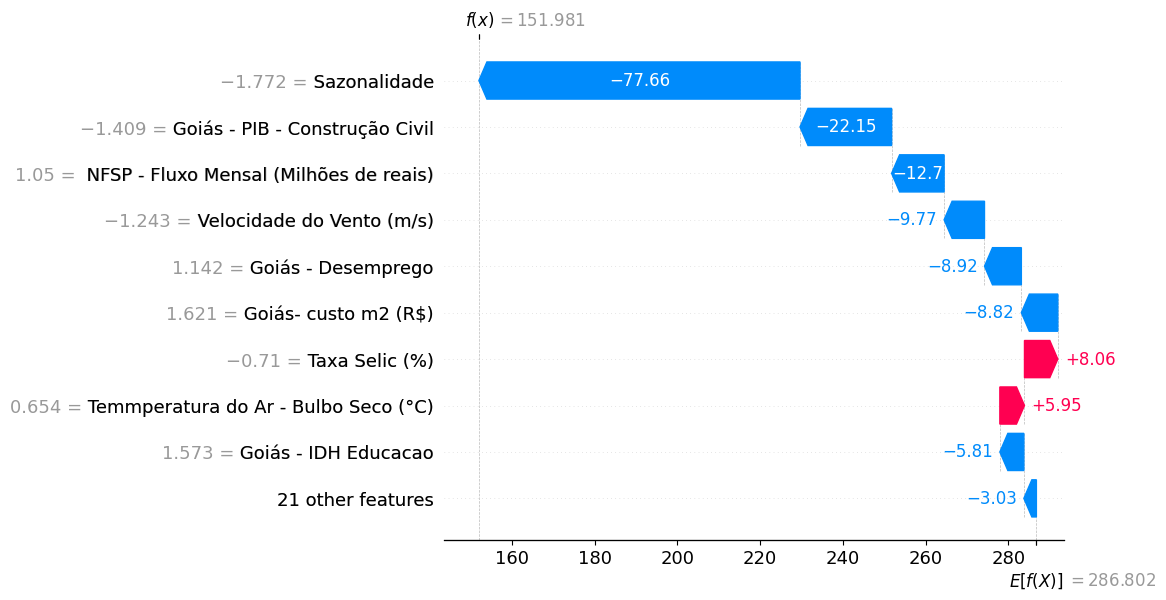

None

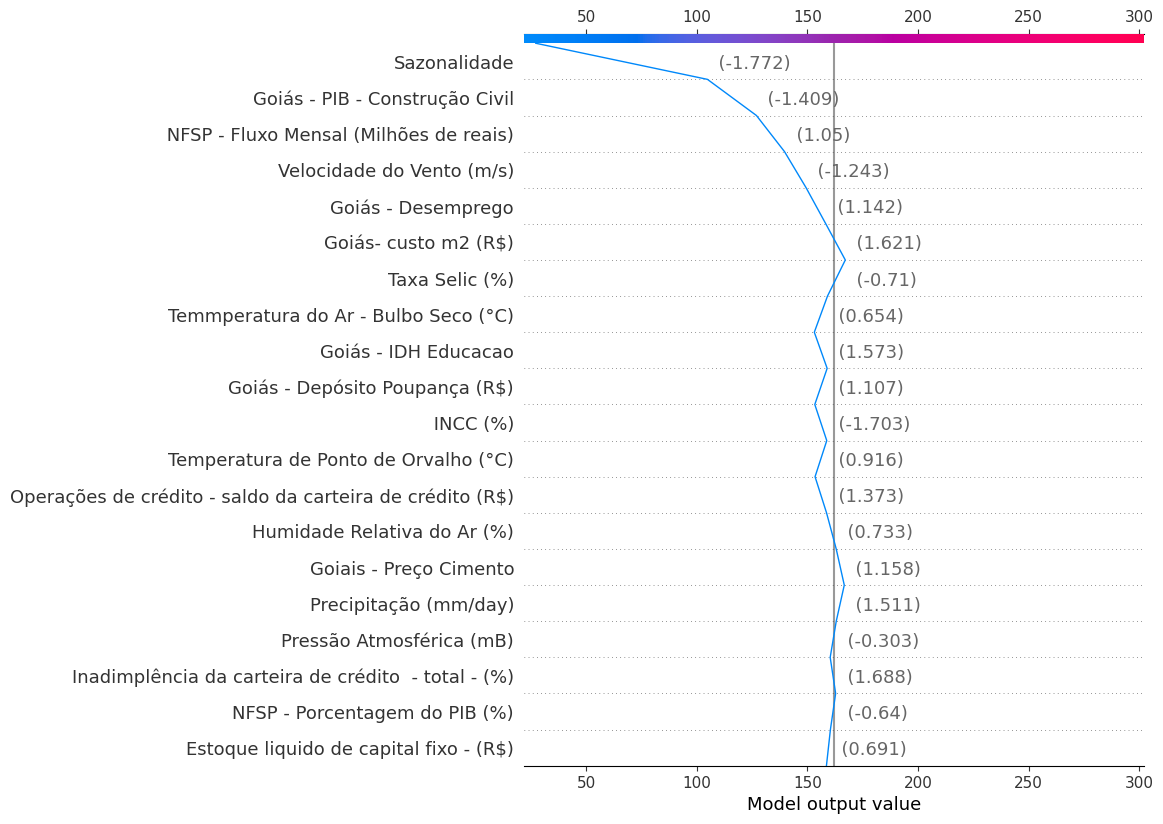

None

['Month-2', 151.98149, 161.936, 9.954514]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 556us/step


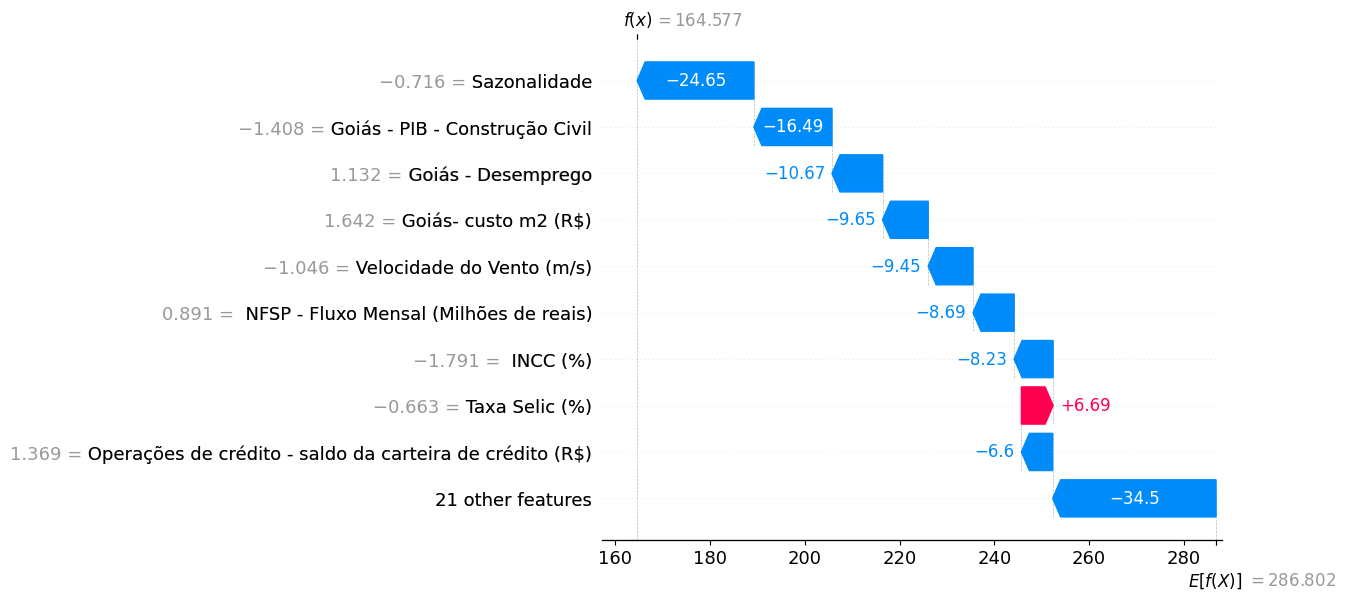

None

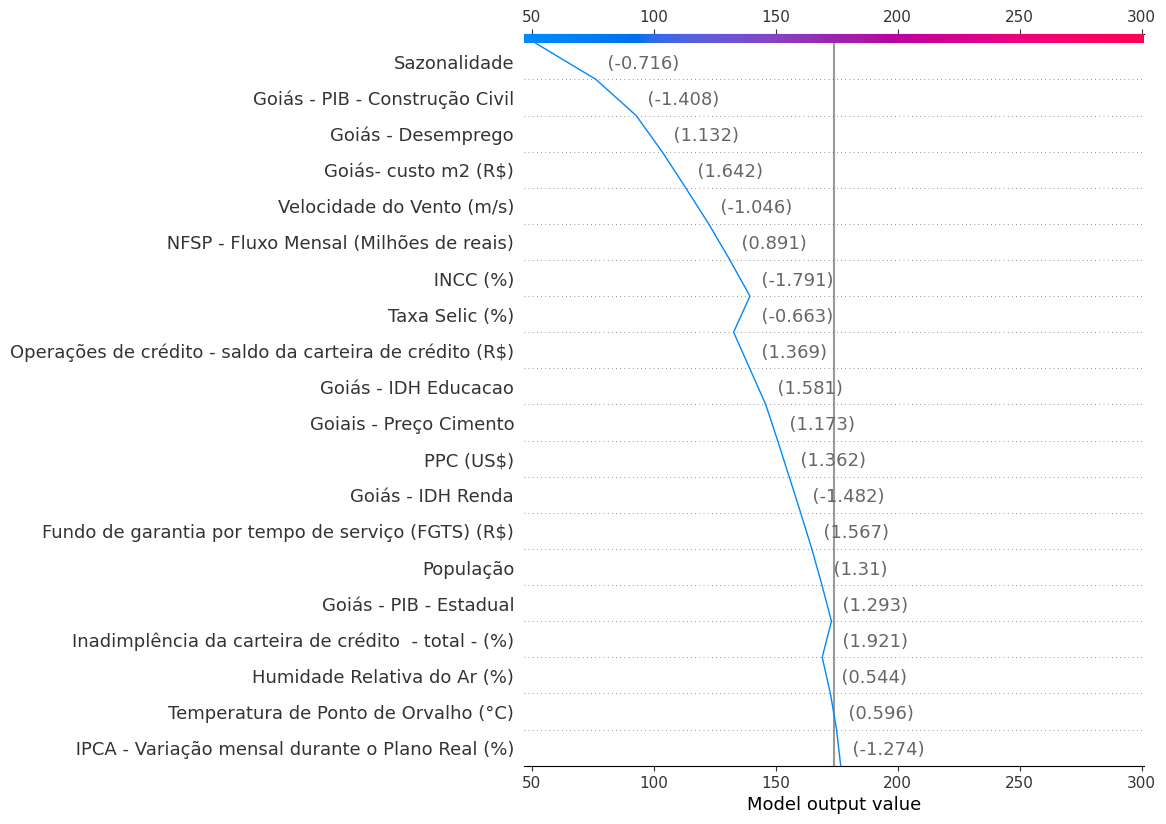

None

['Month-3', 164.5767, 173.792, 9.2153015]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 639us/step


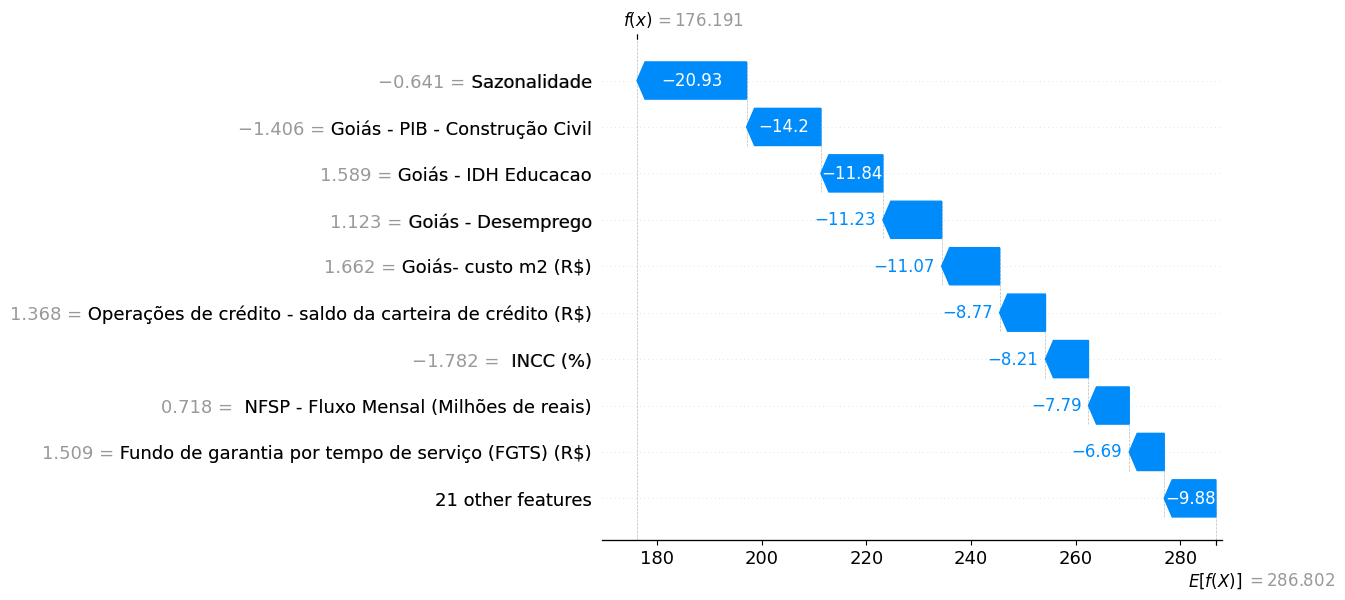

None

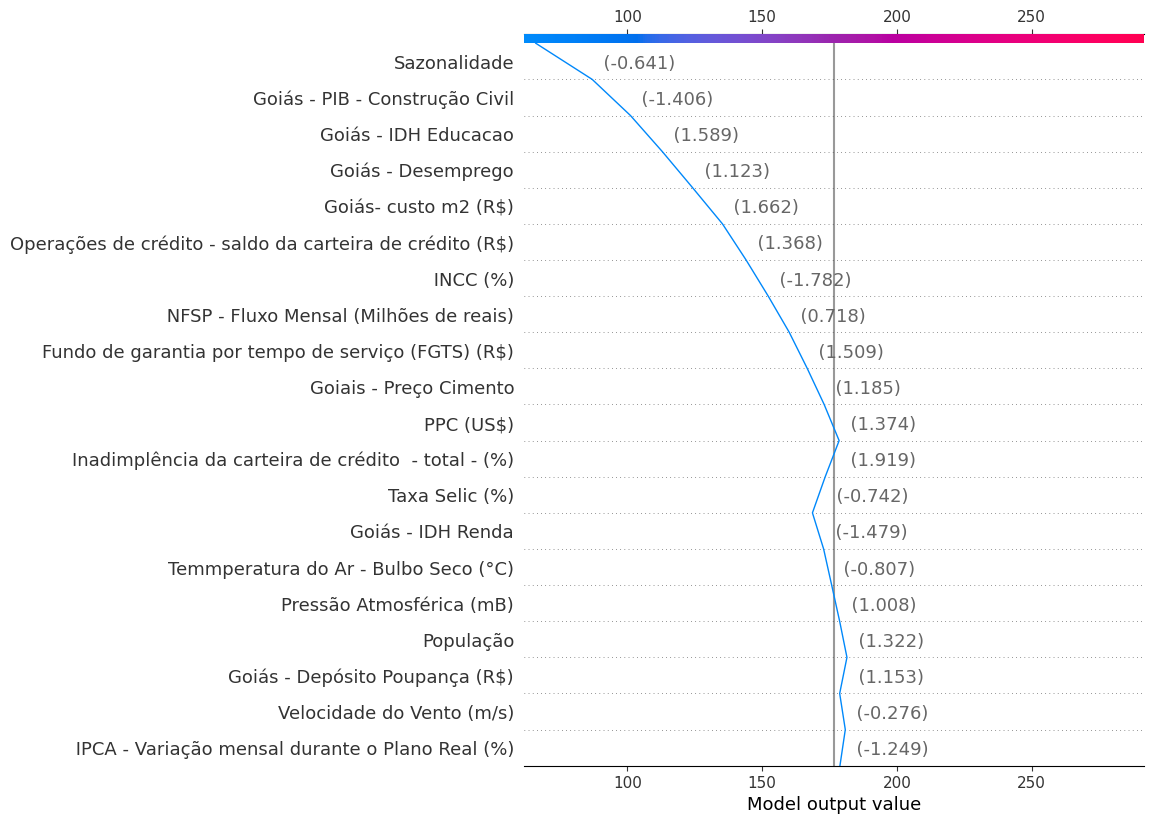

None

['Month-4', 176.1909, 176.627, 0.4360962]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 618us/step


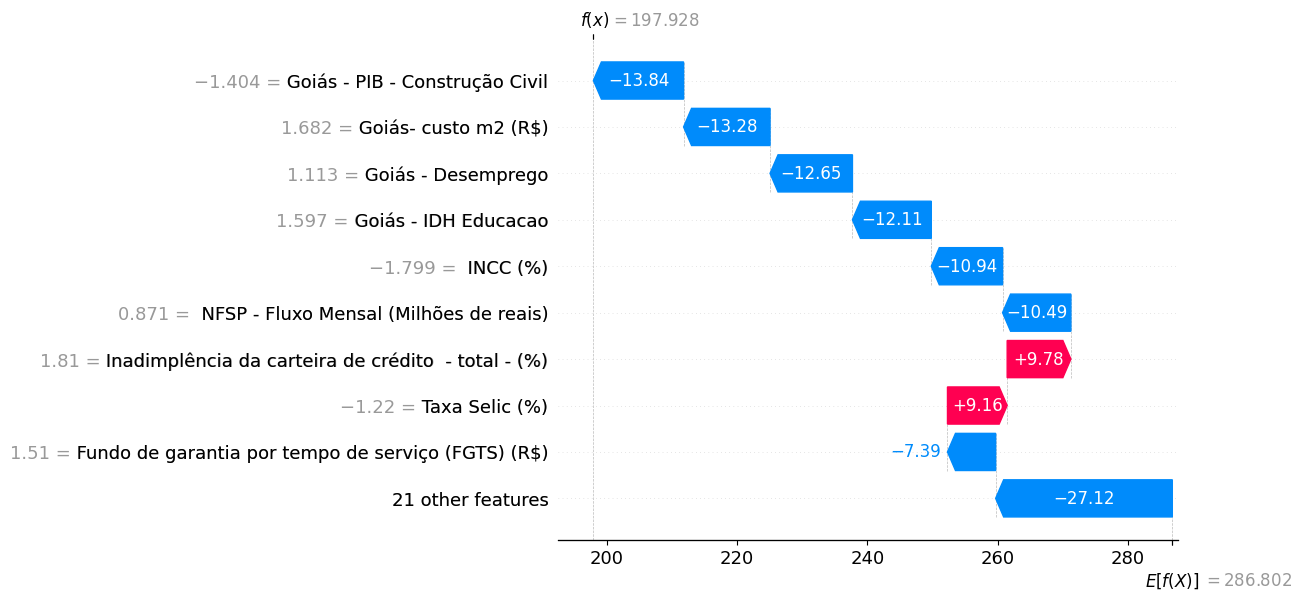

None

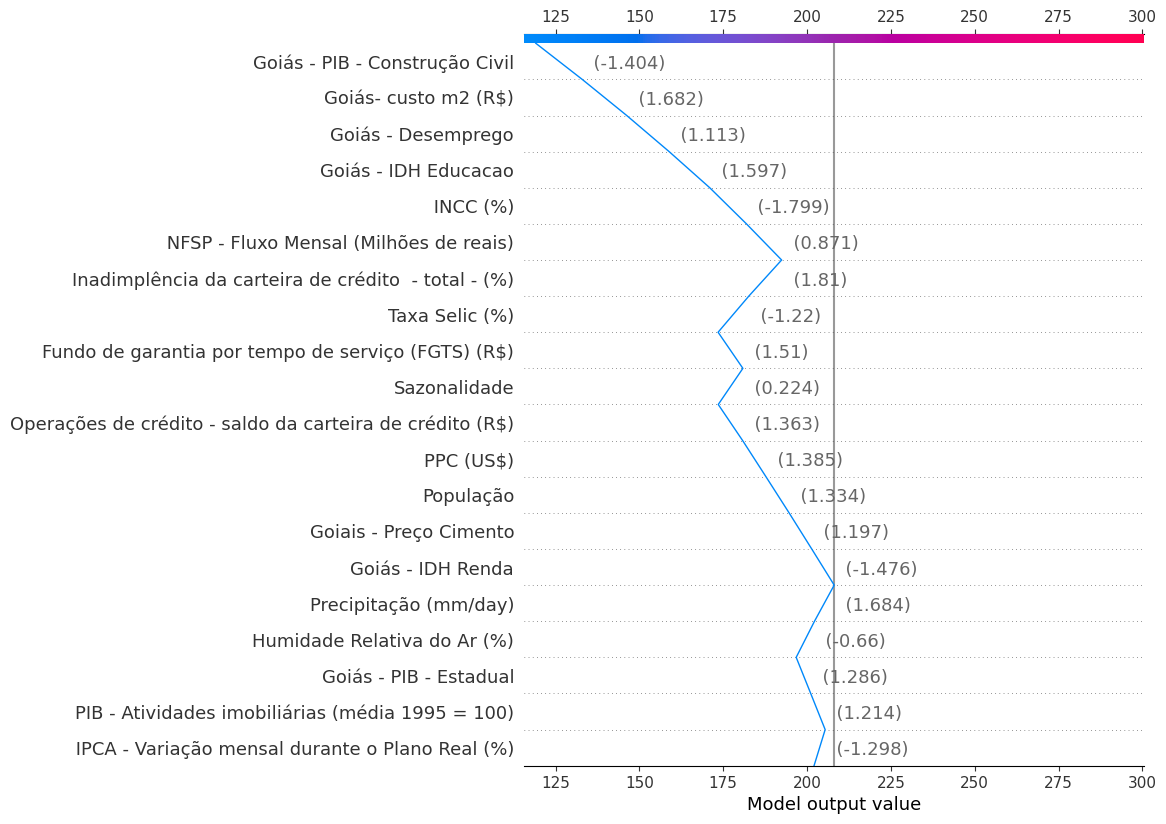

None

['Month-5', 197.92809, 207.991, 10.062912]

1/1 [==============================] - 0s 36ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 605us/step


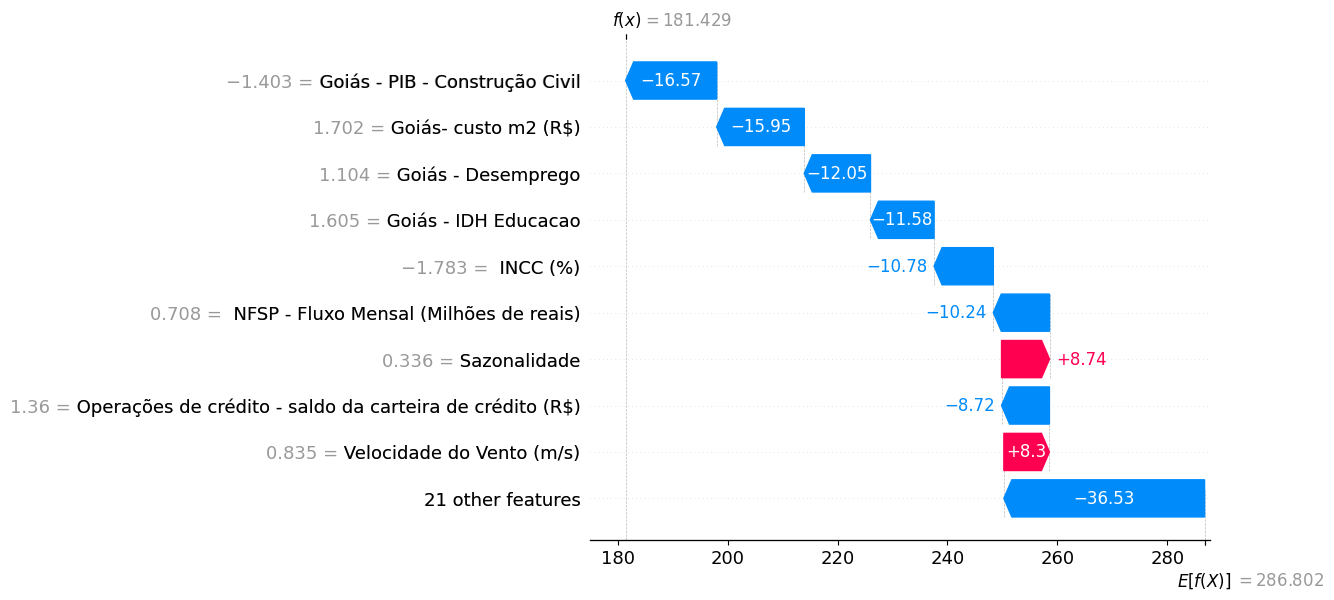

None

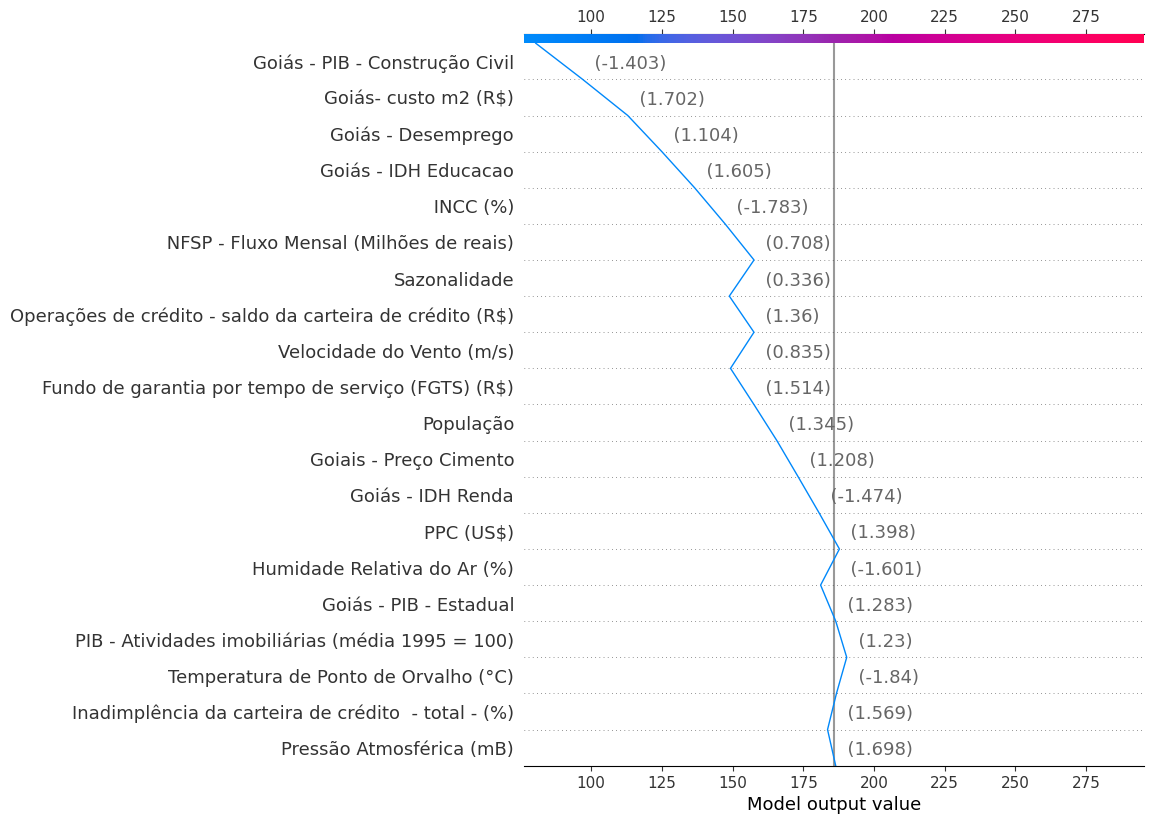

None

['Month-6', 181.42886, 185.784, 4.355133]

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 589us/step


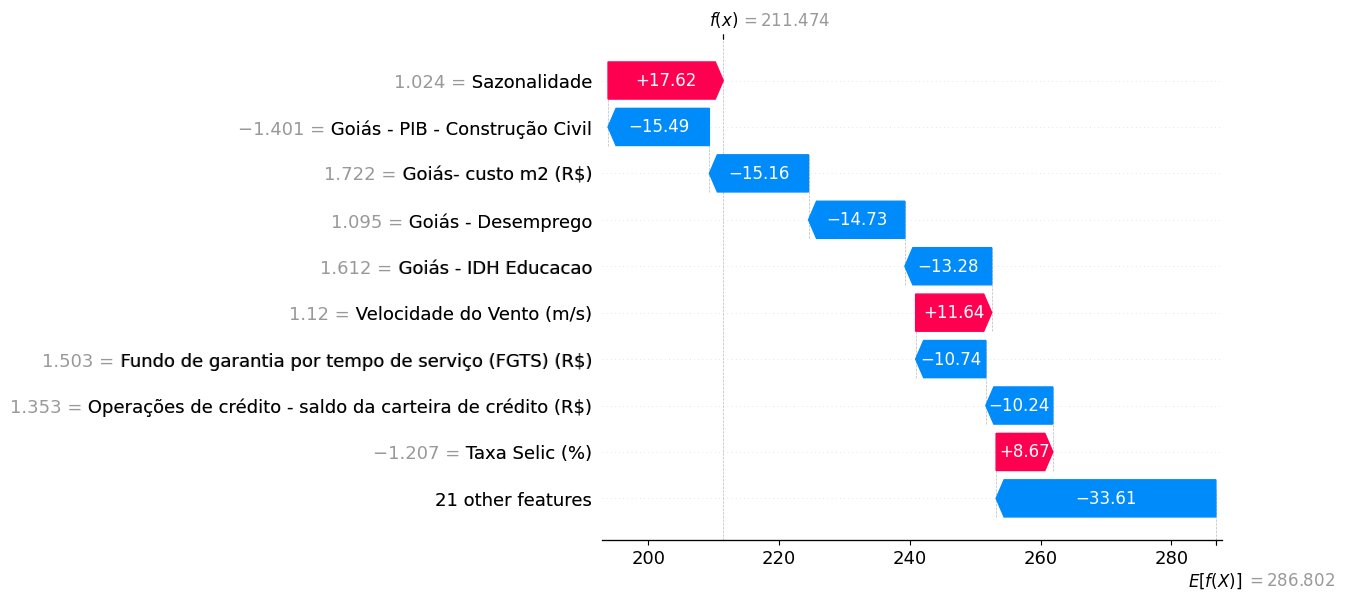

None

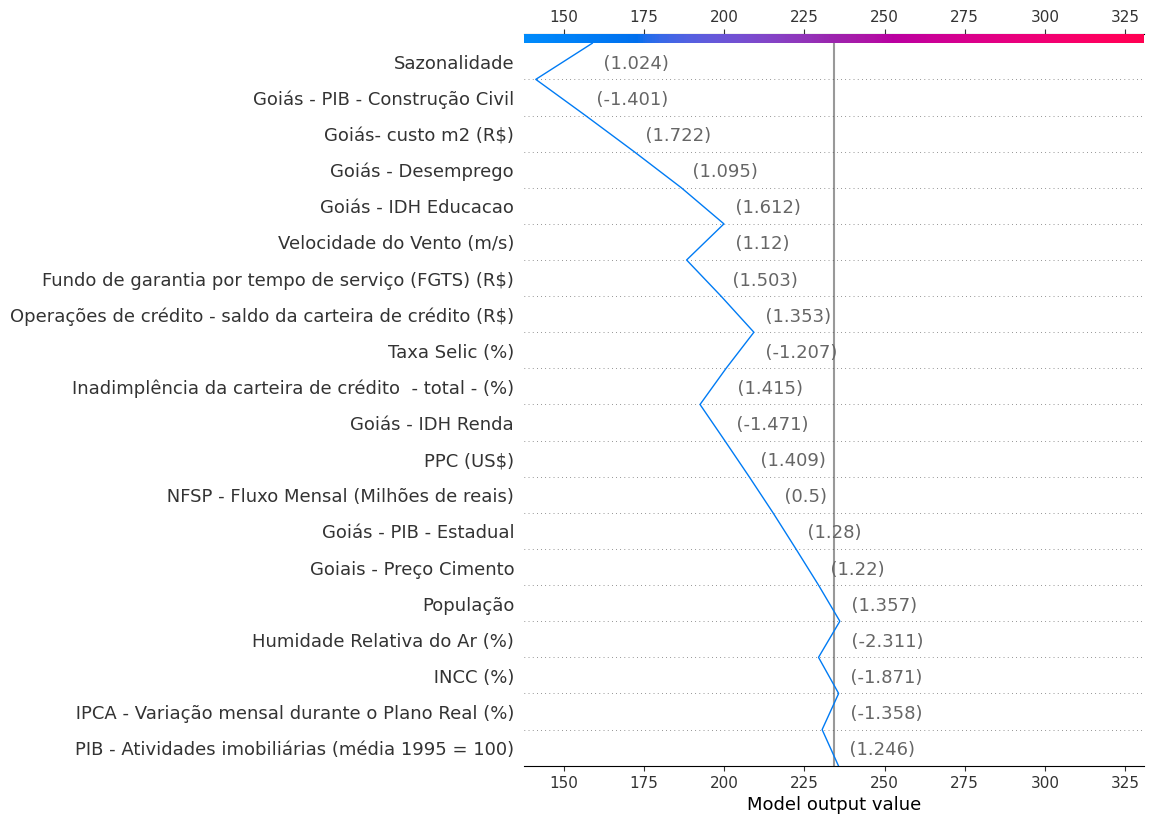

None

['Month-7', 211.47409, 234.176, 22.701904]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 578us/step


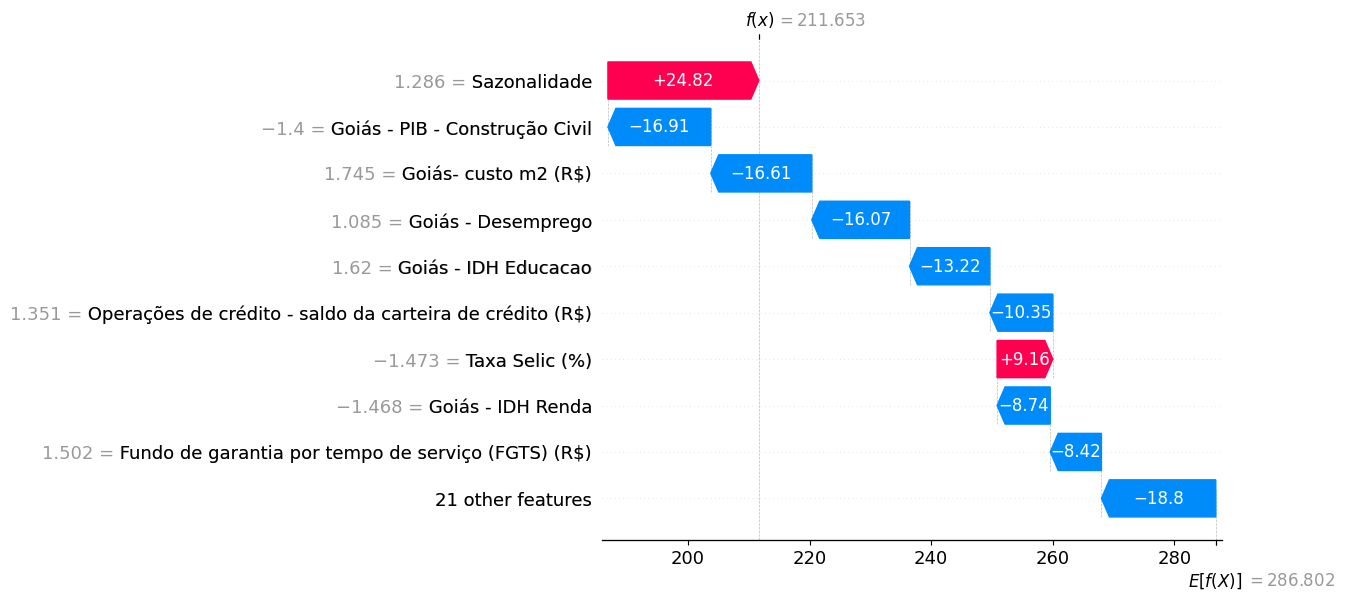

None

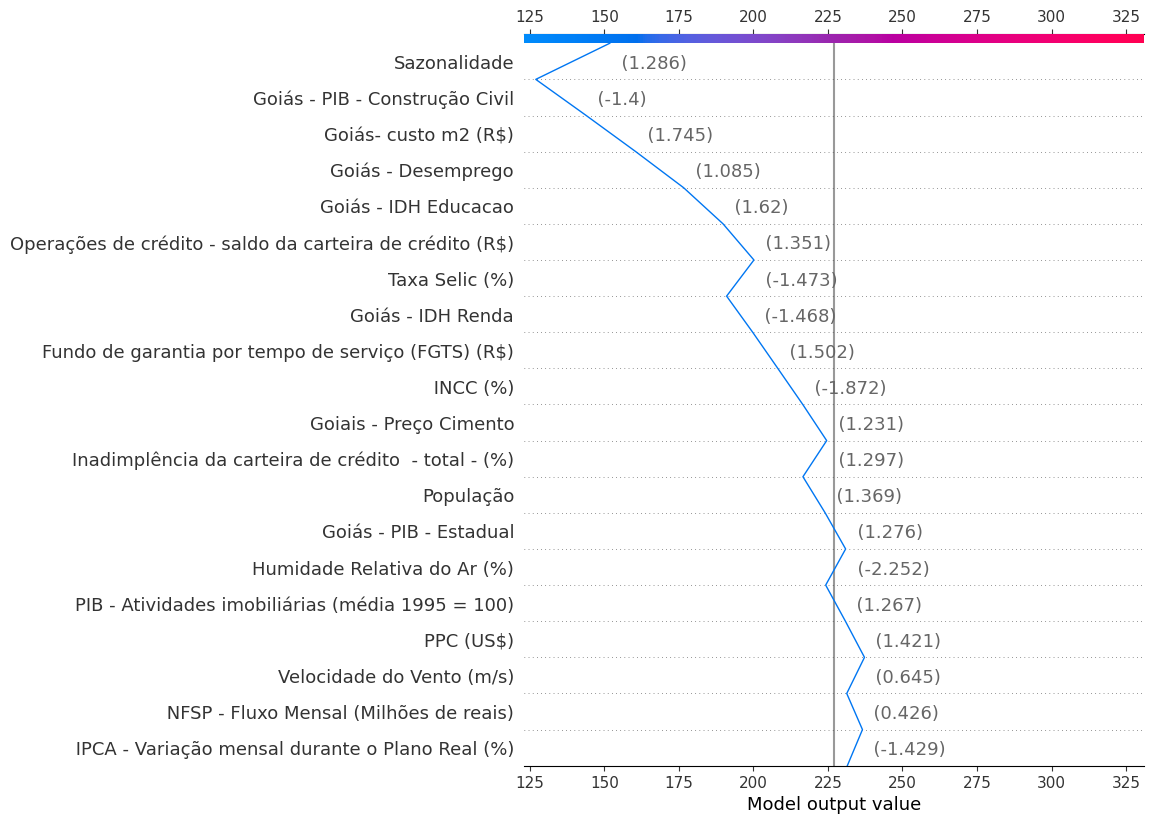

None

['Month-8', 211.65326, 226.996, 15.342743]

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 646us/step


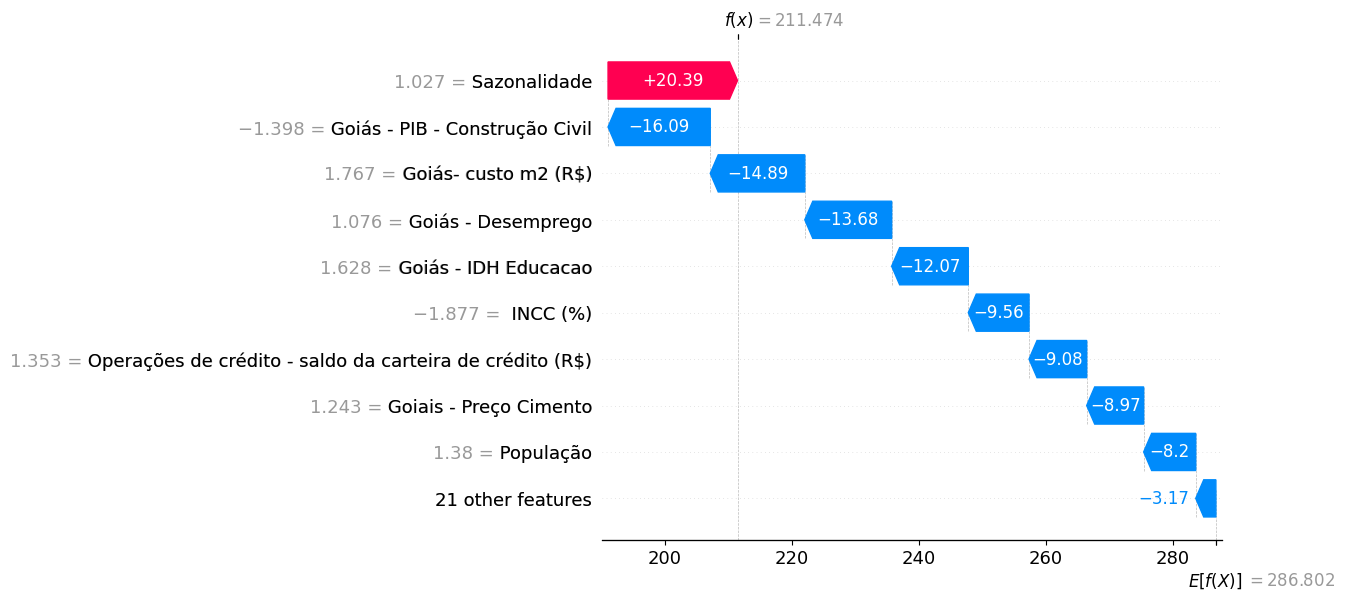

None

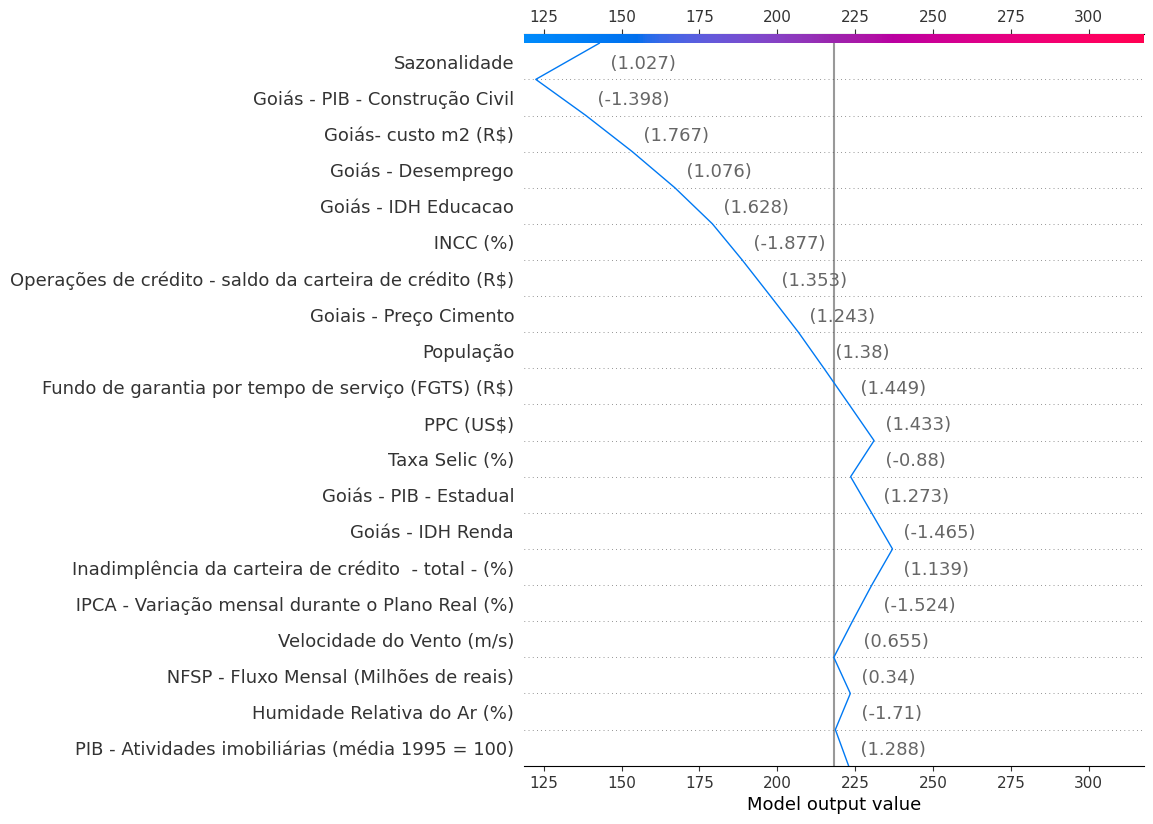

None

['Month-9', 211.47408, 218.141, 6.666931]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 624us/step


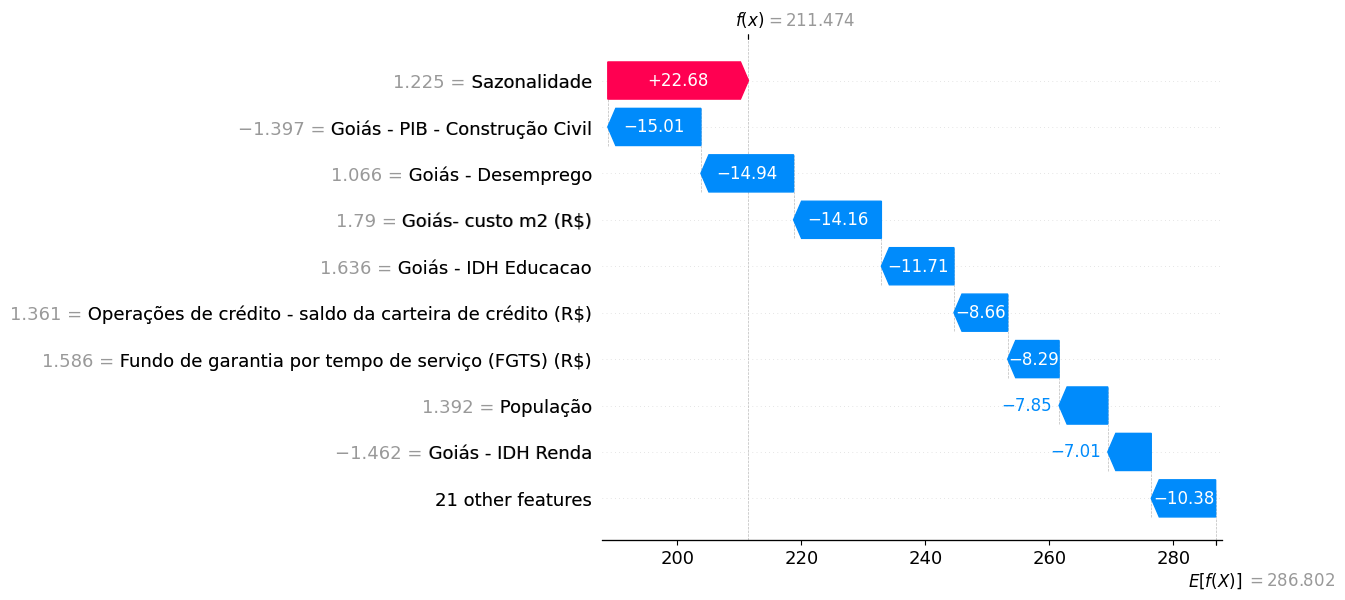

None

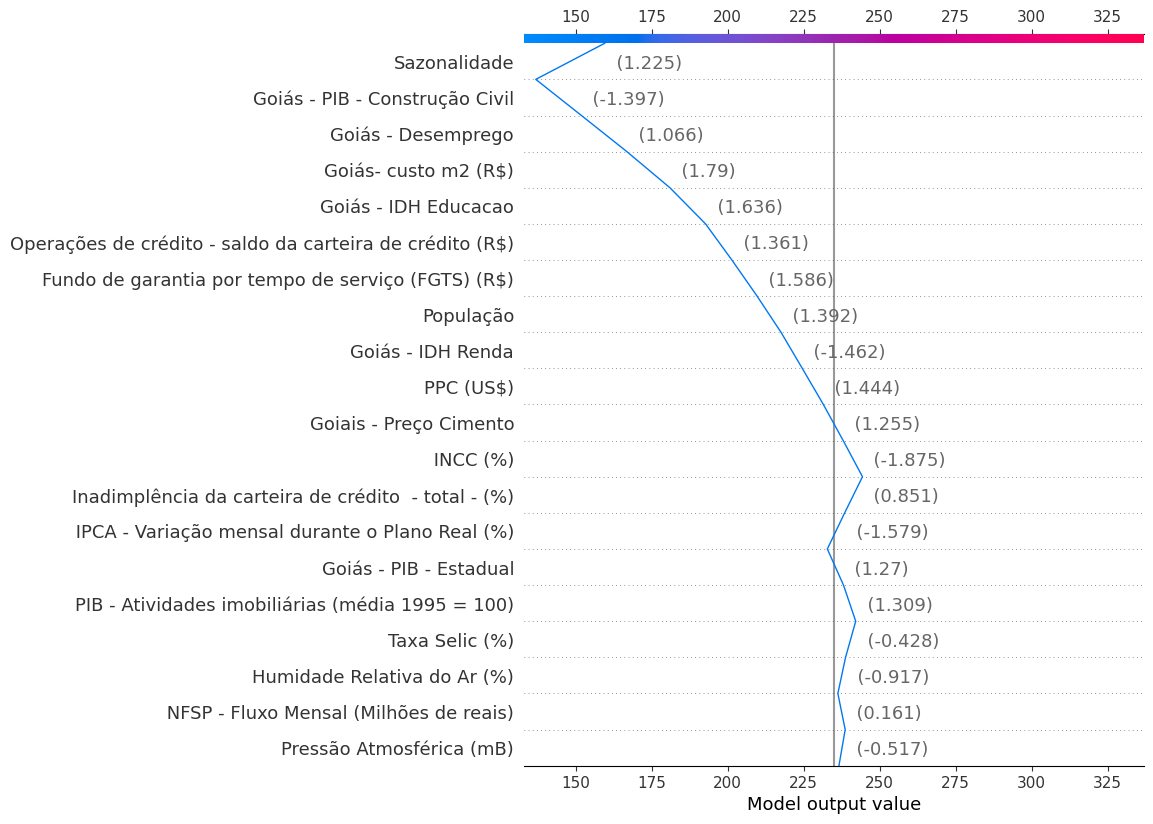

None

['Month-10', 211.47408, 234.939, 23.46492]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 652us/step


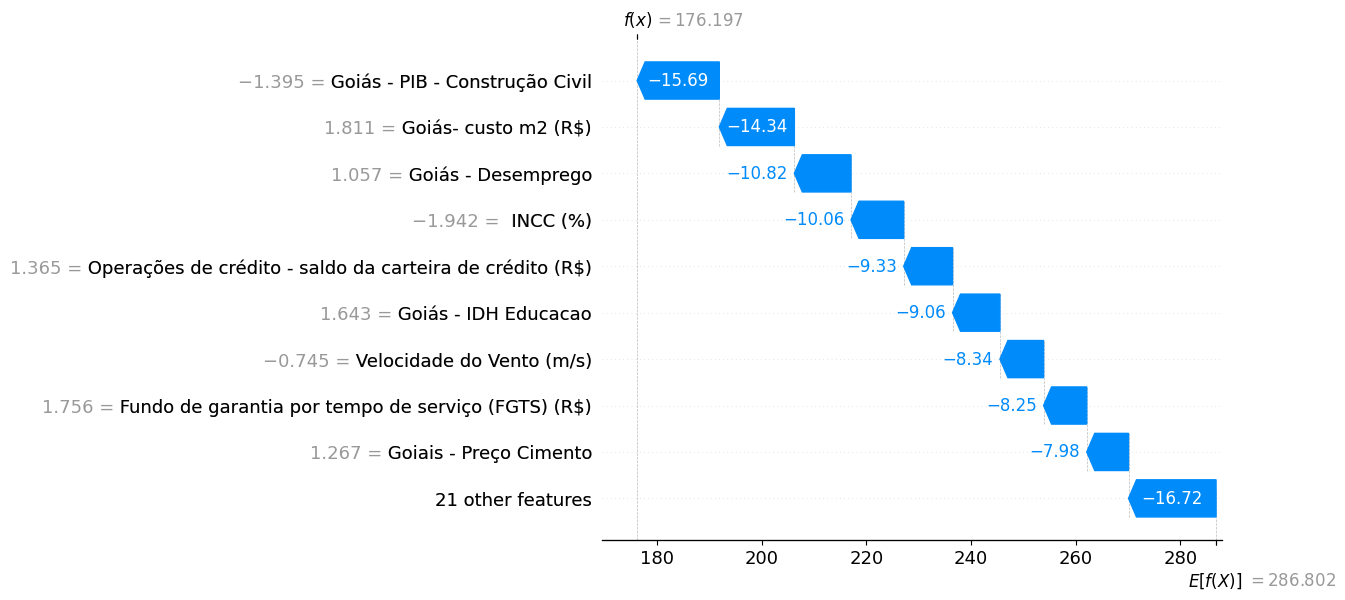

None

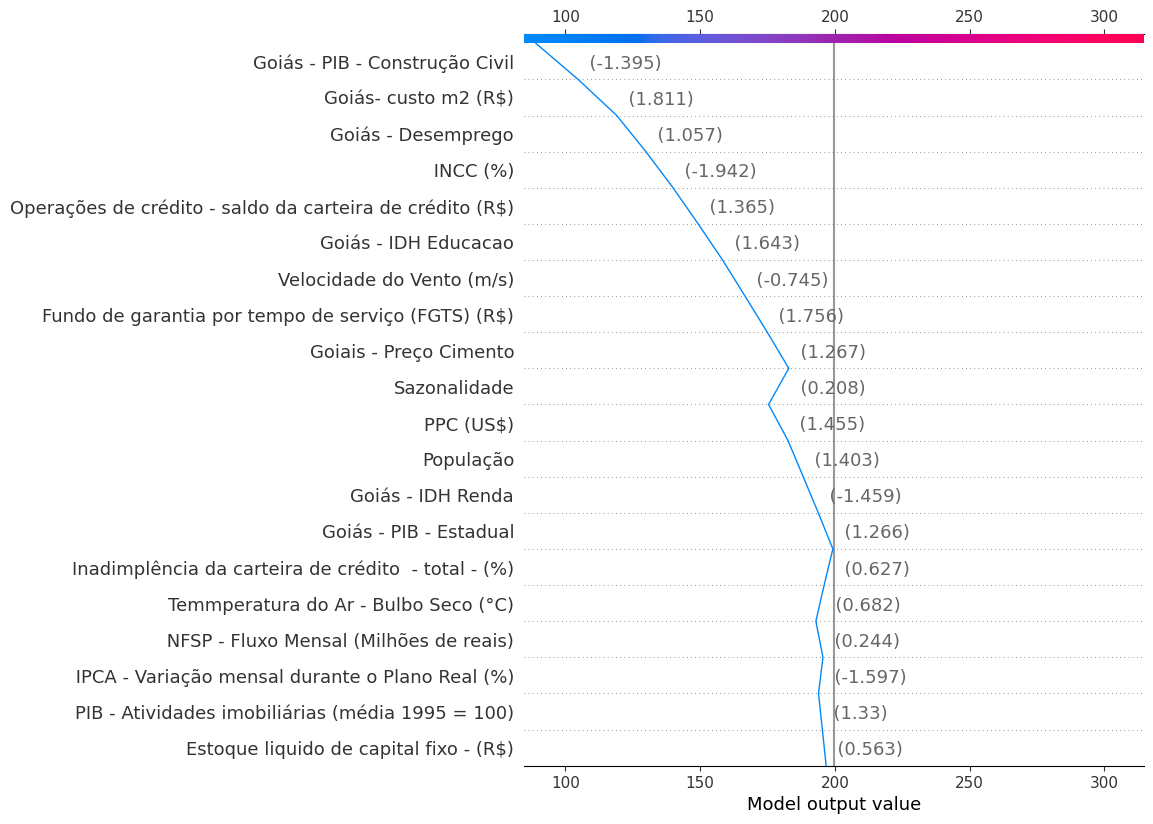

None

['Month-11', 176.19734, 199.619, 23.421661]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 668us/step


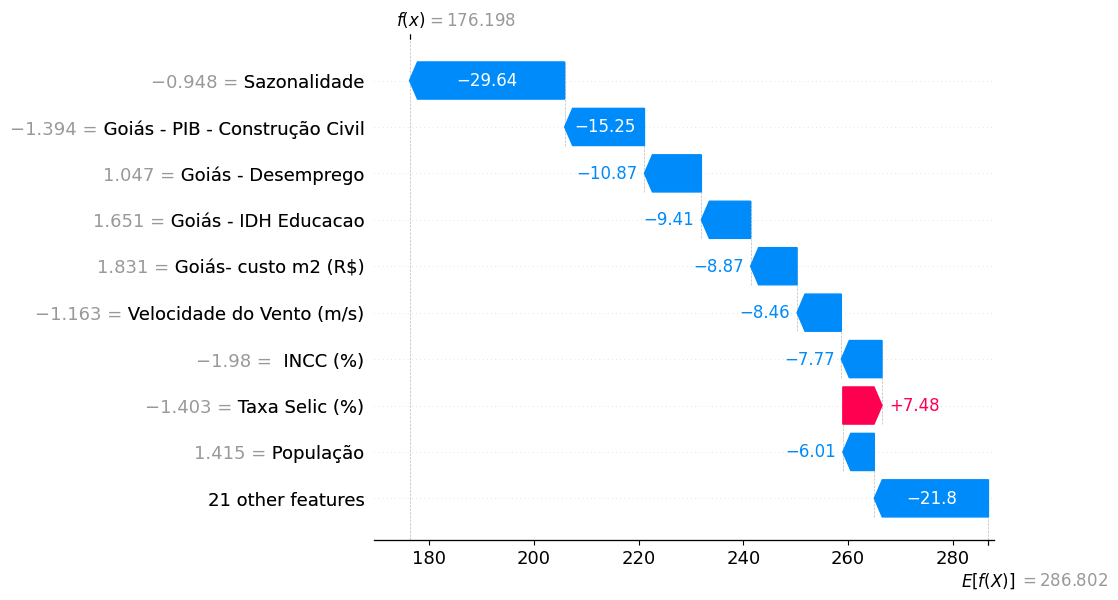

None

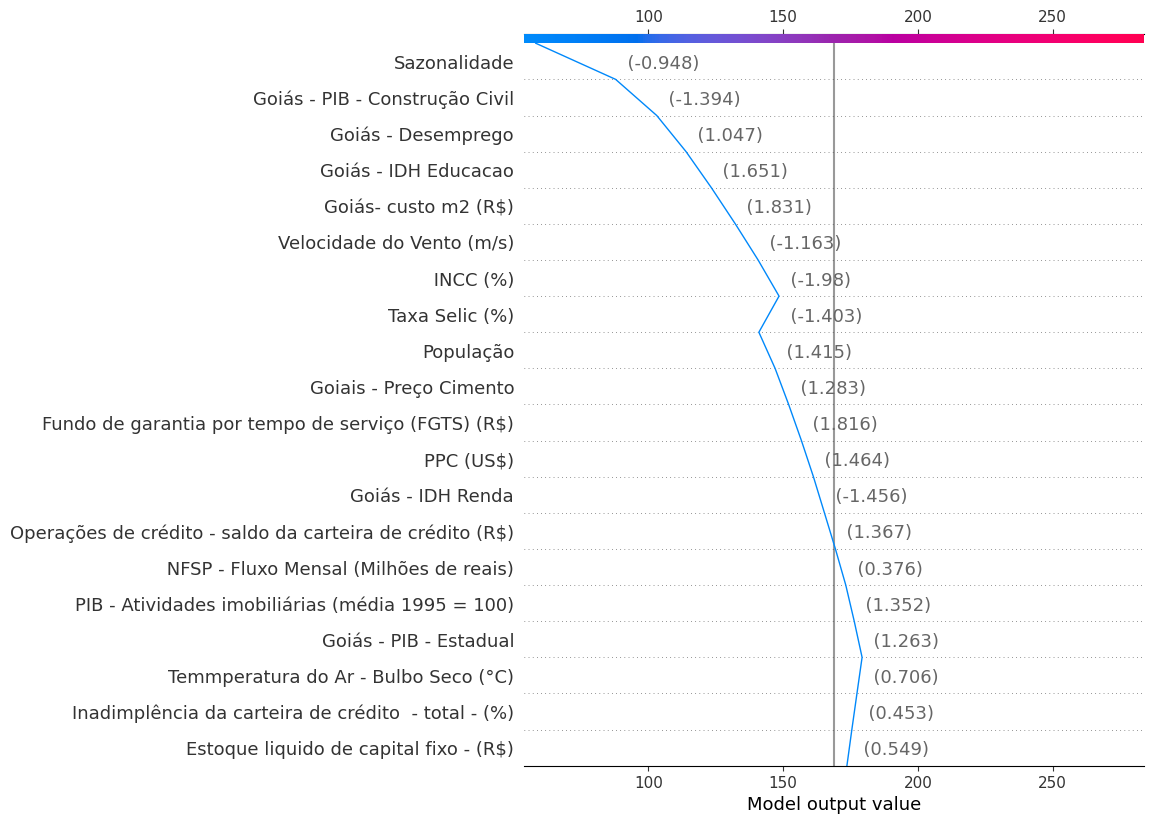

None

['Month-12', 176.19771, 168.797, 7.400711]

0           1           2           3           4   \
Month          Month-1     Month-2     Month-3     Month-4     Month-5   
Prediction  164.564743  151.981491  164.576706  176.190903  197.928085   
Target         178.918     161.936     173.792     176.627     207.991   
Error        14.353256    9.954514    9.215302    0.436096   10.062912   

                    5           6           7           8           9   \
Month          Month-6     Month-7     Month-8     Month-9    Month-10   
Prediction  181.428864  211.474091  211.653259  211.474075  211.474075   
Target         185.784     234.176     226.996     218.141     234.939   
Error         4.355133   22.701904   15.342743    6.666931    23.46492   

                    10          11  
Month         Month-11    Month-12  
Prediction  176.197342  176.197708  
Target         199.619     168.797  
Error        23.421661    7.400711

In [86]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            train_input,
                                            test_input, 
                                            test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

In [87]:
display(mae)
display(mape)

12.281341

0.06043006